In [1]:
!python --version
import os
import warnings

#suppress warnings
warnings.filterwarnings('ignore')

from dask.distributed import LocalCluster
cluster = LocalCluster()          # Fully-featured local Dask cluster
client = cluster.get_client()

client

Python 3.10.16


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 7
Total threads: 28,Total memory: 62.58 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33483,Workers: 7
Dashboard: http://127.0.0.1:8787/status,Total threads: 28
Started: Just now,Total memory: 62.58 GiB
Comm: tcp://127.0.0.1:42527,Total threads: 4
Dashboard: http://127.0.0.1:39685/status,Memory: 8.94 GiB
Nanny: tcp://127.0.0.1:46333,


In [2]:
### use numba to speed up the code
from numba import jit

@jit(nopython=True)
def fast_function():
    pass


### Use Memory-Efficient Pandas Operations
import pandas as pd
pd.options.mode.chained_assignment = None  # Disable warnings
pd.set_option("display.float_format", "{:.4f}".format)  # Reduce memory usage



# 1. Workbook setups

## 1.1 Import packages

In [3]:
import pandas as pd
import numpy as np
import xarray as xr
xr.set_options(file_cache_maxsize=10)

import scipy as scipy
from scipy import stats
import math
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor
import statsmodels.api as sm

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import proplot as plot
import cartopy.crs as ccrs

import shapefile as shp
from shapely.geometry import Point, Polygon
import shapely
from geopy.distance import distance, Distance, lonlat

from matplotlib import font_manager
font_manager.findfont("TeX Gyre Heros")
mpl.rcParams.update({'font.sans-serif':'TeX Gyre Heros',
                    'font.weight': 'normal',
                    'axes.labelweight': 'normal',
                    'axes.titleweight': 'normal',
                    'pdf.fonttype':42,
                    'ps.fonttype':42
                     })

import string
import os
import requests
import io
from tqdm import tqdm
import time
import h5py
import scipy.io

## 1.2 Miscellaneous codes

In [4]:
def round_to_nearest_half_int(num):
    return round(num * 2) / 2

def getClosestPoint_fromLineString(LineString_input,point1):
    if "MultiLineString" in str(type(LineString_input)):
        multiLineString = LineString_input
        len_multiLineString = len(multiLineString.geoms)
        idxMin = np.array([multiLineString.geoms[i].distance(point1) for i in range(len_multiLineString)]).argmin()
        
        LineString = multiLineString.geoms[idxMin]
    elif "Polygon" in str(type(LineString_input)):
        
        polygon_input = LineString_input
        LineString = polygon_input.exterior
        
    else:
        LineString = LineString_input
        
    Coords = LineString.coords
    x, y = Coords.xy

    coords_df = pd.DataFrame({'LON':x,'LAT':y})
    coords_df['LAT_diff'] = abs(point1.y-coords_df.LAT)
    coords_df['LON_diff'] = abs(point1.x-coords_df.LON)
    coords_df['LONLAT_diff_sum'] = coords_df['LAT_diff']+coords_df['LON_diff']
    lat2,lon2 = coords_df.LAT.iloc[coords_df.LONLAT_diff_sum.idxmin()],coords_df.LON.iloc[coords_df.LONLAT_diff_sum.idxmin()]
    point2 = Point(lon2,lat2)
    return point2

def distance_haversine(origin, destination, output_unit='km'):
    import math
    lon1, lat1 = origin
    lon2, lat2 = destination
    
    if output_unit=='km':
        radius = 6371
    elif output_unit=='mi':
        radius = 3956
    elif output_unit=='m':
        radius = 6371000
    
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c
    return d

# Define usefull functions:
def vrange(V): # Return the array value range
    return [np.min(V),np.max(V)]
def vrangec(V): # Return the array value centered range 
    xl = np.max(np.abs(vrange(V)))
    return np.array([-xl,xl])

def nonnan_gradient(array, axis=None, edge_order=1):
  """Computes the gradient of an array, ignoring NaN values.

  Args:
    array: An N-dimensional array containing samples of a scalar function.
    axis: The axis along which to compute the gradient. If None, the gradient
      is computed for all axes.
    edge_order: The order of the accuracy of the approximation at the edges of
      the array.

  Returns:
    An N-dimensional array or a list of N-dimensional arrays representing the
    gradient.
  """

  # Create a mask of non-NaN values.
  mask = np.isfinite(array)

  # Compute the gradient of the masked array.
  gradient = np.gradient(array, axis=axis, edge_order=edge_order)

  # Set the gradient to zero wherever the mask is False.
  for i in range(len(gradient)):
    gradient[i][~mask] = 0

  return gradient

## 1.3 Dictionaries

In [5]:
ringNumbers_dict_zhang16 = {
    'reported_1302':0, 
    'fGDGT_0':0,
    'reported_1300':1,
    'fGDGT_1':1, 
    'reported_1298':2,
    'fGDGT_2':2, 
    'reported_1296':3,
    'fGDGT_3':3,
    'reported_1294':4,
    'fGDGT_4':4,
    'reported_1294_iso':4,
    'fGDGT_4_prime':4,
    'reported_1292':4, 
    'fGDGT_cren':4,
    'reported_1292_iso':4,
    'fGDGT_cren_prime':4,
    'reported_1292_iso2':5,
    'fGDGT_5':5,
    'reported_1290':6,
    'fGDGT_6':6,
    'reported_1290_iso':6,
    'fGDGT_6_prime':6,
    'reported_1288':7,
    'fGDGT_7':7,
    'reported_1288_iso':7,
    'fGDGT_7_prime':7,
    'reported_1286':8,
    'fGDGT_8':8,
    'reported_1286_iso':8,
    'fGDGT_8_prime':8,
}

ringNumbers_dict_revised = {
    'reported_1302':0, 
    'fGDGT_0':0,
    'reported_1300':1,
    'fGDGT_1':1, 
    'reported_1298':2,
    'fGDGT_2':2, 
    'reported_1296':3,
    'fGDGT_3':3,
    'reported_1294':4,
    'fGDGT_4':4,
    'reported_1294_iso':4,
    'fGDGT_4_prime':4,
    'reported_1292':5, 
    'fGDGT_cren':5,
    'reported_1292_iso':5,
    'fGDGT_cren_prime':5,
    'reported_1292_iso2':5,
    'fGDGT_5':5,
    'reported_1290':6,
    'fGDGT_6':6,
    'reported_1290_iso':6,
    'fGDGT_6_prime':6,
    'reported_1288':7,
    'fGDGT_7':7,
    'reported_1288_iso':7,
    'fGDGT_7_prime':7,
    'reported_1286':8,
    'fGDGT_8':8,
    'reported_1286_iso':8,
    'fGDGT_8_prime':8,
}

def label_pvalues(x):
    if x<0.001:
        return r'$\it{P}$<.001'
    elif x<0.01:
        return r'$\it{P}$<.01'
    elif x<0.05:
        return r'$\it{P}$<.05'
    elif x<0.1:
        return r'$\it{P}$<.1'
    elif x>=0.1:
        return r'$\it{P}$>.1'


## 1.4 Set local paths

In [6]:
os

<module 'os' from '/home/ronnie-rattan/miniforge3/envs/nutrient-effect-on-tex/lib/python3.10/os.py'>

In [7]:
# set the path to local folder other than github

### 1.4.1 Local path on PC
local_documents_path = '/home/ronnie-rattan/Documents' ### this is the path when code is run on Linux

### 1.4.2 Path to github folder
gitpath_idx = os.getcwd().find('nutrient-effect-on-TEX')+len('nutrient-effect-on-TEX')
local_github_path = os.getcwd()[:gitpath_idx]

### 1.4.3 Path to OneDrive folder
local_onedrive_path = '/home/ronnie-rattan/OneDrive'

# 2. Import data

## 2.1 Processed coretop_df_full


In [8]:
local_github_path

'/home/ronnie-rattan/Documents/GitHub/nutrient-effect-on-TEX'

In [9]:
fpath = fr'{local_github_path}/spreadsheets'
fname = 'ds03_processed_coretop_tex.csv'

coretop_df = pd.read_csv(f'{fpath}/{fname}')
coretop_df

,sampleID,index_column,core_name,core_type,sample_depth_start,sample_depth_end,Latitude,Longitude,modernWaterDepth,TEX86,...,thermocline_depth,thermocline_T,thermocline_T_depthIntegral,SSN,thermocline_nitrate,thermocline_nitrate_depthIntegral,region_ID,regionName,pred_tex,tex_residuals
0,RR00001,JET_RR_00001,GeoB7702-3,GC,5.0000,6.0000,31.6517,34.0733,562.0000,0.6620,...,55.0000,19.0069,21.5897,0.0882,0.0039,0.0257,NaN,NaN,0.5920,0.0700
1,RR00002,JET_RR_00002,KNR195-5-5 MC11,MC,6.0000,8.0000,-1.5327,-86.7852,2288.0000,0.6029,...,25.0000,20.8615,22.5202,4.0946,8.3004,5.3182,10.0000,East Equatorial Pacific,0.6019,0.0010
2,RR00003,JET_RR_00003,KNR195-5-6 MC12,MC,0.0000,1.0000,-3.7105,-81.1153,378.0000,0.5700,...,15.0000,20.7300,22.0932,3.5177,5.8044,4.2084,NaN,NaN,0.5974,-0.0274
3,RR00004,JET_RR_00004,KNR195-5-7 MC16,MC,0.0000,1.0000,-3.7502,-81.1358,379.0000,0.5720,...,15.0000,20.5830,22.0416,4.4152,7.1120,5.3783,NaN,NaN,0.5968,-0.0248
4,RR00005,JET_RR_00005,KNR195-5-8 MC18,MC,4.0000,6.0000,-3.9690,-81.3100,1024.0000,0.5994,...,15.0000,20.1193,21.3194,4.3262,6.4625,4.9695,10.0000,East Equatorial Pacific,0.5892,0.0103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2097,RR02100,JET_RR_02100,AMD17_BB2_BC,NaN,NaN,NaN,72.7500,-67.0200,2373.0000,0.3469,...,20.0000,-0.9438,-0.3832,2.8648,3.6252,3.0592,60.0000,Baffin Bay,0.3589,-0.0119
2098,RR02101,JET_RR_02101,AMD17_CASQ1_BC-4,NaN,NaN,NaN,71.4100,-70.8900,702.0000,0.3529,...,5.0000,-0.0741,0.5383,3.0020,2.9467,2.9743,60.0000,Baffin Bay,0.3687,-0.0157
2099,RR02102,JET_RR_02102,AMD17_176_BC,NaN,NaN,NaN,69.6000,-65.4000,267.0000,0.4000,...,10.0000,-0.8792,-0.6309,3.0862,3.1556,3.1075,60.0000,Baffin Bay,0.3563,0.0437
2100,RR02103,JET_RR_02103,AMD17_8.1_BC,NaN,NaN,NaN,69.4100,-64.4000,1054.0000,0.3226,...,10.0000,-0.8413,-0.5349,2.9766,3.0433,2.9951,60.0000,Baffin Bay,0.3573,-0.0347


In [10]:
import matplotlib.colors as mcolors
##### concatenate three colormaps

colors1 = plot.get_colors('tab10')
colors2 = plot.get_colors('tab20b')
colors3 = plot.get_colors('538')
colors4 = plot.get_colors('tab20c')
colors5 = plot.get_colors('bmh')

combined_cmap = np.concatenate((colors1,colors2,colors3,colors4,colors5))
extended_cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap',combined_cmap)
#########
region_list_full = coretop_df['regionName'].unique()
color_list_full = plot.get_colors(extended_cmap,len(region_list_full))

region_color_dict_full = dict(zip(region_list_full,color_list_full))
region_color_dict_full

region_color_dict_full_rgb = {k:mpl.colors.to_rgba(v) for k,v in region_color_dict_full.items()}
region_color_dict_full_rgb

{nan: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 'East Equatorial Pacific': (0.984313725490196,
  0.5019607843137255,
  0.058823529411764705,
  1.0),
 'Mozambique Channel': (0.2, 0.6078431372549019, 0.17254901960784313, 1.0),
 'Pacific-Southern Ocean': (0.8235294117647058,
  0.16862745098039217,
  0.19215686274509805,
  1.0),
 'Tasman-Antarctica 140E Transect': (0.5686274509803921,
  0.3803921568627451,
  0.592156862745098,
  1.0),
 'NZ-SW Pacific': (0.6705882352941176,
  0.3843137254901961,
  0.4588235294117647,
  1.0),
 'Equatorial Pacific': (0.7450980392156863,
  0.47843137254901963,
  0.6627450980392157,
  1.0),
 'West Equatorial Pacific': (0.592156862745098,
  0.592156862745098,
  0.3568627450980392,
  1.0),
 'Tonga-Tropical South Pacific': (0.3058823529411765,
  0.7450980392156863,
  0.5843137254901961,
  1.0),
 'South China Sea': (0.1803921568627451,
  0.39215686274509803,
  0.5803921568627451,
  1.0),
 'Chilean Offshore': (0.29411764705882354,
  0.3019

In [11]:
regionName_df = coretop_df.pivot_table(index=('region_ID','regionName'),values='TEX86',aggfunc='count').reset_index()[['region_ID','regionName']]
regionID_to_regionName_dict = dict(zip(regionName_df['region_ID'],regionName_df['regionName']))
regionID_to_regionName_dict


{1.0: 'Amundsen Sea',
 2.0: 'Arabian Sea',
 3.0: 'Arctic Ocean',
 4.0: 'Baltic Sea',
 5.0: 'Bering Sea',
 6.0: 'Black Sea',
 7.0: 'Chilean Offshore',
 8.0: 'Chukchi Sea',
 9.0: 'Drake Passage',
 10.0: 'East Equatorial Pacific',
 11.0: 'Eastern Indian Ocean (Offshore Indonesia)',
 12.0: 'Eastern North America Offshore',
 13.0: 'Eastern South America Offshore',
 14.0: 'Greenland Sea',
 15.0: 'Gulf of Aqaba',
 16.0: 'Gulf of California',
 17.0: 'Gulf of Mexico',
 18.0: 'Hudson Bay',
 19.0: 'Indian Ocean Gyre',
 20.0: 'Indonesian Throughflow',
 21.0: 'Japan Sea',
 22.0: 'Kara Sea',
 23.0: 'Laptev Sea',
 24.0: 'Mediterranean',
 25.0: 'Mozambique Channel',
 26.0: 'North Atlantic',
 27.0: 'North Sea',
 28.0: 'Northern Pacific',
 29.0: 'NZ-SW Pacific',
 30.0: 'Pacific-Southern Ocean',
 31.0: 'Red Sea',
 32.0: 'Ross Sea',
 33.0: 'Santa Barbara Bay',
 34.0: 'SE Pacific',
 35.0: 'Sea of Okhotsk',
 36.0: 'South Africa Offshore',
 37.0: 'South Atlantic Gyre',
 38.0: 'South China Sea',
 39.0: 'South

## 2.2 Calculated ocean products

### 2.2.1 WOA23 thermocline-integrated temperatures and thermocline depths

In [12]:
fpath2 = fr'{local_documents_path}/Postdoc/TEXAS-PSM/netcdf/WOA-database/WOA23/WOA-decav'
ts = xr.open_dataset(os.path.join(fpath2,'woa23_decav91C0_t00_04.nc'),decode_times=False).drop('time')

T_da = ts.isel(time=0).t_an.load()
T_da

<xarray.DataArray 't_an' (depth: 102, lat: 720, lon: 1440)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.6605101, -1.66081  , -1.65491  , ..., -1.6598101,
         -1.66031  , -1.66041  ],
        [-1.66861  , -1.66521  , -1.66721  , ..., -1.66961  ,
         -1.6665   , -1.66871  ],
        [-1.44921  , -1.44921  , -1.44921  , ..., -1.44921  ,
         -1.44921  , -1.44921  ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Objectively analyzed mean fields for sea_water_temperatur...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          degrees_celsius

In [13]:
fpath = fr'{local_github_path}/netcdf_files'
fname = 'ds06_calculated_ocean_properties.nc'

t_sf2tc_da = xr.open_dataset(f'{fpath}/{fname}',decode_times=False).t_sf2tc_avg
t_sf2tc_da

<xarray.DataArray 't_sf2tc_avg' (lat: 720, lon: 1440)>
[1036800 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9

In [14]:
fpath = fr'{local_github_path}/netcdf_files'
fname = 'ds06_calculated_ocean_properties.nc'

thermocline_depth_da = xr.open_dataset(os.path.join(fpath,fname),decode_times=False).tc_depth
thermocline_depth_da

<xarray.DataArray 'tc_depth' (lat: 720, lon: 1440)>
[1036800 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9

### 2.2.2 CMEMS thermocline-integrated nitrate concentrations

In [15]:
### thermocline depthIntegral Nitrate
fpath = fr'{local_github_path}/netcdf_files'
fname = 'ds06_calculated_ocean_properties.nc'

thermocline_nitrate_da = xr.open_dataset(os.path.join(fpath,fname),decode_times=False).no3_sf2tc_avg
thermocline_nitrate_da

<xarray.DataArray 'no3_sf2tc_avg' (lat: 720, lon: 1440)>
[1036800 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9

## 2.3 Gridded TEX

In [16]:
fpath = fr'{local_github_path}/netcdf_files'
fname = 'ds04_gridded_coretop_tex.nc'
gridded_coretop_ds = xr.open_dataset(os.path.join(fpath,fname))
gridded_coretop_ds

<xarray.Dataset>
Dimensions:        (lat: 720, lon: 1440)
Coordinates:
  * lat            (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon            (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    region_ID      (lon, lat) float64 ...
    tex_count      (lon, lat) float64 ...
    tex_median     (lon, lat) float64 ...
    tex_mean       (lon, lat) float64 ...
    tex_std        (lon, lat) float64 ...
    tex_residuals  (lon, lat) float64 ...
Attributes:
    title:             Gridded coretop TEX86 data
    long_name:         statistics of TEX86 for each grid cell with the same l...
    units:             TEX86 [unitless], thermocline-integrated T [degC], dep...
    summary:           This dataset contains climatological annual means (199...
    data_sources:      Global Ocean Biogeochemistry Hindcast (CMEMS); World O...
    processing_level:  Derived product
    history:           Computed from the global compilation of core-top GDGT ...
    references:        This study

## 2.4 Gridded amOxRate data

In [17]:
fpath = fr'{local_github_path}/netcdf_files'
fname = 'ds05_gridded_AOM_ds.nc'
merged_ammOxR_gridded_ds = xr.open_dataset(os.path.join(fpath,fname))
merged_ammOxR_gridded_ds

<xarray.Dataset>
Dimensions:           (lat: 720, lon: 1440, depth: 55)
Coordinates:
  * lat               (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon               (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * depth             (depth) float32 0.0 5.0 10.0 ... 2.5e+03 3e+03 3.5e+03
Data variables: (12/16)
    ammOxRate_count   (lat, lon, depth) float64 ...
    ammOxRate_median  (lat, lon, depth) float64 ...
    ammOxRate_mean    (lat, lon, depth) float64 ...
    ammOxRate_std     (lat, lon, depth) float64 ...
    NH4_count         (lat, lon, depth) float64 ...
    NH4_median        (lat, lon, depth) float64 ...
    ...                ...
    NO2_mean          (lat, lon, depth) float64 ...
    NO2_std           (lat, lon, depth) float64 ...
    NO3_count         (lat, lon, depth) float64 ...
    NO3_median        (lat, lon, depth) float64 ...
    NO3_mean          (lat, lon, depth) float64 ...
    NO3_std           (lat, lon, depth) float64 ...
Attributes:
    title:             Gridded Ammonia Oxidation Data
    summary:           This dataset contains gridded ammonia oxidation data f...
    data_sources:      Global Ocean Ammonia Oxidation Database (Tang et al. 2...
    processing_level:  Derived product
    history:           Gridded from the original dataset by interpolating to ...
    Conventions:       CF-1.7
    references:        Tang et al. 2023

## 2.5 Global nitrification database by Tang et al. (2023)

In [18]:
fpath = fr'{local_github_path}/spreadsheets/published_data'
fname = r'Weiyi23_EarthSystSciData_nitrification_database.xlsx'

global_AOA_df = pd.read_excel(os.path.join(fpath,fname),sheet_name='ammonia oxidizer')
global_AOA_df = global_AOA_df.rename(
    columns={
        'Depth (m)': 'Depth',
        'shallow clade AOA (copies L-1)': 'shallow_clade_AOA_copiesL', 
        'deep clade AOA (copies L-1)': 'deep_clade_AOA_copiesL',
        'total AOA (copies L-1)': 'total_AOA_copiesL', 
        'Thaumarchaeota 16S rRNA (copies L-1)': 'Thaum_16S_rRNA_copiesL',
        ' βAOB (copies L-1)': 'beta_AOB_copiesL', 
        'shallow clade AOA transcript (copies L-1)': 'shallow_clade_AOA_transcript_copiesL',
        'deep clade AOA transcript (copies L-1)': 'deep_clade_AOA_transcript_copiesL',
        'total AOA transcript (copies L-1)': 'total_AOA_transcript_copiesL', 
        ' βAOB transcript (copies L-1)': 'beta_AOB_transcript_copiesL',
        'PAR (μmol Einstein m-2 s-1)': 'PAR', 
        'Light level (%)': 'light_level', 
        'Temperature (°C)': 'insituT',
        'Salinity (psu)': 'insituS', 
        'Potential density (kg m-3)': 'insituSigmaT', 
        'Ammonium+ammonia (μM)': 'NH4_uM',
        'Nitrite (μM)': 'NO2_uM', 
        'Nitrate (μM)': 'NO3_uM', 
        'O2 (μM)': 'insituOxy'}
    )
global_AOA_df

,Data source,data_source,Date,Latitude,Longitude,Depth,shallow_clade_AOA_copiesL,deep_clade_AOA_copiesL,total_AOA_copiesL,Thaum_16S_rRNA_copiesL,...,PAR,light_level,insituT,insituS,insituSigmaT,NH4_uM,NO2_uM,NO3_uM,pH,insituOxy
0,"Agogue et al., 2008. Nature","Agogue et al., 2008",2002 September,61.6300,-20.8200,2071.0000,2360000,NaN,NaN,78400000,...,NaN,NaN,2.4160,34.9830,27.9240,NaN,NaN,NaN,NaN,292.3000
1,"Agogue et al., 2008. Nature","Agogue et al., 2008",2002 September,61.6300,-20.8200,1633.0000,498000.0000,NaN,NaN,13900000.0000,...,NaN,NaN,3.2630,34.9520,27.8220,NaN,NaN,NaN,NaN,287.4000
2,"Agogue et al., 2008. Nature","Agogue et al., 2008",2002 September,61.6300,-20.8200,1014.0000,2390000,NaN,NaN,135000000,...,NaN,NaN,5.5520,35.0650,27.6600,NaN,NaN,NaN,NaN,247.8000
3,"Agogue et al., 2008. Nature","Agogue et al., 2008",2002 September,61.6300,-20.8200,498.0000,4680000,NaN,NaN,39900000,...,NaN,NaN,7.8250,35.1960,27.4550,NaN,NaN,NaN,NaN,265.9000
4,"Agogue et al., 2008. Nature","Agogue et al., 2008",2002 September,61.6300,-20.8200,99.0000,7080000,NaN,NaN,63100000.0000,...,NaN,NaN,9.0890,35.2280,27.2830,NaN,NaN,NaN,NaN,264.2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2244,"Zhang et al., 2020. PNAS.","Zhang et al., 2020",2015 April,30.0000,147.0000,500.0000,NaN,NaN,623000,969342.7681,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2245,"Zhang et al., 2020. PNAS.","Zhang et al., 2020",2015 April,30.0000,147.0000,650.0000,NaN,NaN,1620000,2356267.4720,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2246,"Zhang et al., 2020. PNAS.","Zhang et al., 2020",2015 April,30.0000,147.0000,750.0000,NaN,NaN,1460000,3740288.1866,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2247,"Zhang et al., 2020. PNAS.","Zhang et al., 2020",2015 April,30.0000,147.0000,800.0000,NaN,NaN,1360000,2532082.0546,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
fpath = fr'{local_github_path}/spreadsheets/published_data'
fname = r'Weiyi23_EarthSystSciData_nitrification_database.xlsx'

global_AOM_df = pd.read_excel(os.path.join(fpath,fname),sheet_name='volumetric ammonia oxidation')
global_AOM_df = global_AOM_df.rename(
    columns={
        'Depth (m)':'Depth',
        'Rate (nmol N L-1 d-1)':'ammoniaOxidationRate', 
        'Standard deviation of rate (nmol N L-1 d-1)':'AOR_std',
        'PAR (μmol Einstein m-2 s-1)':'PAR',
        'Light level (%)':'light_level',
        'Temperature (°C)':'insituT',
        'Salinity (psu)':'insituS',
        'Potential density (kg m-3)':'insituSigmaT',
        'Ammonium+ammonia (μM)':'NH4_uM',
        'Nitrite (μM)':'NO2_uM',
        'Nitrate (μM)':'NO3_uM',
        'O2 (μM)':'insituOxy'}
    )
global_AOM_df = global_AOM_df.replace(
    {'NM':np.nan,
     'BDL':np.nan,}
)

In [20]:
global_AOM_df['thermocline_depth'] = np.nan

for i in range(len(global_AOM_df)):
    lookup_lat = global_AOM_df['Latitude'][i]
    lookup_lon = global_AOM_df['Longitude'][i]
    
    try:
        thermocline_depth_tmp = thermocline_depth_da.sel(lat=lookup_lat,lon=lookup_lon,method='nearest').values
        global_AOM_df['thermocline_depth'][i] = thermocline_depth_tmp
        
    except:
        continue
    

In [21]:
global_AOM_df['thermocline_depth_position'] = global_AOM_df['Depth']-global_AOM_df['thermocline_depth']

## 2.6 Global sedimentary d15N database by NICOPP (Tesdal et al., 2013)

https://www.ncei.noaa.gov/access/paleo-search/study/14114

### 2.6.1 Coretop dataset

In [22]:
fpath = fr'{local_github_path}/spreadsheets/published_data/NICOPP_d15Nsed_database'
fname = 'NICOPP_coretop_published_130307.mat'

mat_cortop = scipy.io.loadmat(os.path.join(fpath,fname))
print(mat_cortop.keys())
print(mat_cortop['__header__'])

dict_keys(['__header__', '__version__', '__globals__', 'ctop_pub'])
b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Thu Mar  7 20:13:16 2013'


In [23]:

df_tmp = []
features = ['name','region','ref',
            'lat','lon','depth','d15N',]
for i in range(len(mat_cortop['ctop_pub'][0][0][0])):
    for feature in features:
        if ('name' in feature) or ('region' in feature) or ('ref' in feature):
            try:
                sel_feature = (mat_cortop['ctop_pub'][feature][0][0][i])[0][0]
            except:
                sel_feature = np.nan
        else:
            try:
                sel_feature = (mat_cortop['ctop_pub'][feature][0][0][i])[0]
            except:
                sel_feature = np.nan
        df_tmp.append(sel_feature)
        

### convert df_tmp into a dataframe with 7 columns
coretop_d15N_df = pd.DataFrame(np.reshape(df_tmp, (2176,7)),columns=features)
coretop_d15N_df

### covert datatype of columns
coretop_d15N_df = coretop_d15N_df.astype({'lat':float,'lon':float,'depth':float,'d15N':float})
coretop_d15N_df


,name,region,ref,lat,lon,depth,d15N
0,ODP 1228,Eastern Pacific,Agnihotri et al. (2006),-11.0642,-78.0778,273.0000,5.3506
1,ODP 1229,Iberian Margin,Alt-Epping et al. (2007),38.6345,-9.4542,NaN,5.6000
2,ODP 1230,Iberian Margin,Alt-Epping et al. (2007),38.6250,-9.5083,102.0000,5.8000
3,ODP 1231,Iberian Margin,Alt-Epping et al. (2007),38.6922,-9.2606,19.0000,6.3000
4,ODP 1232,Iberian Margin,Alt-Epping et al. (2007),38.6461,-9.4242,54.0000,6.1000
...,...,...,...,...,...,...,...
2171,EW0408-084 MC-7,Gulf of Alaska,Walinsky et al. (2009),59.5300,-144.1300,686.0000,3.3000
2172,EW0408-091 MC-8,Gulf of Alaska,Walinsky et al. (2009),59.6500,-145.1500,198.0000,2.5000
2173,EW0408-094 MC-8,Gulf of Alaska,Walinsky et al. (2009),60.6600,-147.7100,744.0000,3.7000
2174,EW0408-097 MC-8,Gulf of Alaska,Walinsky et al. (2009),60.5600,-146.7700,401.0000,4.2000


In [24]:
### gridded coretop d15N
mid_lat_array = thermocline_depth_da.lat.values
mid_lon_array = thermocline_depth_da.lon.values

coretop_d15N_df['match_lat'] = [mid_lat_array[np.abs(mid_lat_array-lat).argmin()] for lat in coretop_d15N_df['lat']]
coretop_d15N_df['match_lon'] = [mid_lon_array[np.abs(mid_lon_array-lon).argmin()] for lon in coretop_d15N_df['lon']]

features = ['match_lat','match_lon','d15N']
pregridded_coretop_d15N_df = coretop_d15N_df[features]
pregridded_coretop_d15N_df = pregridded_coretop_d15N_df.dropna().reset_index(drop=True)

new_features = ['d15N_count','d15N_median','d15N_mean','d15N_std']
agg_func_list = ['count','median','mean','std']
for i, new_feature in enumerate(features):
    pregridded_coretop_d15N_df[new_features[i]] = pregridded_coretop_d15N_df.groupby([
        'match_lat','match_lon'])['d15N'].transform(agg_func_list[i])
    
pregridded_coretop_d15N_df = pregridded_coretop_d15N_df.drop_duplicates(
    subset=['match_lat','match_lon'],keep='first').reset_index(drop=True)

coretop_gridded_d15N_da = xr.Dataset.from_dataframe(pregridded_coretop_d15N_df.set_index(['match_lat','match_lon']))
coretop_gridded_d15N_da = coretop_gridded_d15N_da.rename({'match_lon':'lon','match_lat':'lat'})
## nan mask
# coretop_gridded_d15N_da = coretop_gridded_d15N_da.where(coretop_gridded_d15N_da['d15N_count']>1)
coretop_gridded_d15N_da

    
### combine all dataarrays into a single dataset
SST_da = thermocline_depth_da
coretop_gridded_d15N_ds = xr.merge([SST_da,coretop_gridded_d15N_da]).drop_vars(['tc_depth','d15N'])
coretop_gridded_d15N_ds

<xarray.Dataset>
Dimensions:      (lat: 720, lon: 1440)
Coordinates:
  * lat          (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon          (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Data variables:
    d15N_count   (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    d15N_median  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    d15N_mean    (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan

### 2.6.2 Downcore dataset

In [25]:
fpath = fr'{local_github_path}/spreadsheets/published_data/NICOPP_d15Nsed_database'
fname = 'NICOPP_downcore_published_130307.mat'

mat_data = scipy.io.loadmat(os.path.join(fpath,fname))
print(mat_data.keys())
print(mat_data['__header__'])

dict_keys(['__header__', '__version__', '__globals__', 'core_pub'])
b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Thu Mar  7 13:22:48 2013'


In [26]:
tmp_df = []
for i in range(len(mat_data['core_pub']['name'][0])):
    core_name = np.squeeze(mat_data['core_pub']['name'][0][i])
    core_lat = np.squeeze(mat_data['core_pub']['lat'][0][i])
    core_lon = np.squeeze(mat_data['core_pub']['lon'][0][i])
    core_depth = np.squeeze(mat_data['core_pub']['depth'][0][i])
    try:
        core_depth = np.atleast_1d(core_depth).astype(float)[0]
    except:
        core_depth = np.nan
    core_ref = np.squeeze(mat_data['core_pub']['ref'][0][i])
    core_acidified = np.squeeze(mat_data['core_pub']['acidified'][0][i])
    
    ### check if age and d15N data are available for the core
    age_len = len(mat_data['core_pub']['age'][0][i])
    d15N_len = len(mat_data['core_pub']['d15N'][0][i])
    mbsf_len = len(mat_data['core_pub']['mbsf'][0][i])
    N_len = len(mat_data['core_pub']['N'][0][i])
    Corg_len = len(mat_data['core_pub']['Corg'][0][i])
    if (age_len == d15N_len) and (age_len>0):
        ### before loop through age and d15N data, check if the core has mbsf, N, and Corg data
        for j in range(age_len):
            age = np.squeeze(mat_data['core_pub']['age'][0][i][j])
            d15N = np.squeeze(mat_data['core_pub']['d15N'][0][i][j])
            
            if mbsf_len==age_len:
                mbsf = np.squeeze(mat_data['core_pub']['mbsf'][0][i][j])
            else:
                ### nan with the same length as age and d15N
                mbsf = np.nan
            
            if N_len==age_len:
                N = np.squeeze(mat_data['core_pub']['N'][0][i][j])
            else:
                ### nan with the same length as age and d15N
                N = np.nan
                
            if Corg_len==age_len:
                Corg = np.squeeze(mat_data['core_pub']['Corg'][0][i][j])
            else:
                ### nan with the same length as age and d15N
                Corg = np.nan
                
            tmp_df.append([core_name,core_lat,core_lon,core_depth,core_ref,core_acidified,age,d15N,mbsf,N,Corg])

downcore_d15N_df = pd.DataFrame(tmp_df, columns=['core_name', 'Latitude', 'Longitude',
                                                 'modernWaterDepth', 'ref', 'acidified',
                                                 'Age', 'd15N', 'mbsf', 'N', 'Corg'])

# Convert columns to appropriate data types
downcore_d15N_df = downcore_d15N_df.astype({
    'core_name': str,
    'Latitude': float,
    'Longitude': float,
    # 'modernWaterDepth': float,
    'ref': str,
    'acidified': str,
    'Age': float,
    'd15N': float,
    'mbsf': float,
    'N': float,
    'Corg': float
})

downcore_d15N_df

,core_name,Latitude,Longitude,modernWaterDepth,ref,acidified,Age,d15N,mbsf,N,Corg
0,AII 125-8 JPC-56,27.4693,-112.1043,818.0000,Pride et al. (1999),n,5.4600,10.9000,1.0100,NaN,NaN
1,AII 125-8 JPC-56,27.4693,-112.1043,818.0000,Pride et al. (1999),n,5.7602,11.2600,1.2500,NaN,NaN
2,AII 125-8 JPC-56,27.4693,-112.1043,818.0000,Pride et al. (1999),n,6.0854,11.5900,1.5100,NaN,NaN
3,AII 125-8 JPC-56,27.4693,-112.1043,818.0000,Pride et al. (1999),n,6.3856,11.4600,1.7500,NaN,NaN
4,AII 125-8 JPC-56,27.4693,-112.1043,818.0000,Pride et al. (1999),n,6.6983,11.7650,2.0000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
33543,ODP 745,-59.5952,85.8600,4082.0000,Billups et al. (2013),n,6395.8000,3.5585,209.0000,NaN,NaN
33544,ODP 745,-59.5952,85.8600,4082.0000,Billups et al. (2013),n,6422.3000,3.8386,210.5000,NaN,NaN
33545,ODP 745,-59.5952,85.8600,4082.0000,Billups et al. (2013),n,6447.0000,2.4970,212.0000,NaN,NaN
33546,ODP 745,-59.5952,85.8600,4082.0000,Billups et al. (2013),n,6469.9000,3.9018,213.5000,NaN,NaN


In [27]:
mat_data['core_pub']['age'][0][3]

array([[ 5.46      ],
       [ 5.76018809],
       [ 6.08539185],
       [ 6.38557994],
       [ 6.69827586],
       [ 7.01097179],
       [ 7.3862069 ],
       [ 7.63636364],
       [ 7.97407524],
       [ 8.26175549],
       [ 8.88714734],
       [ 9.26238245],
       [ 9.491     ],
       [ 9.696     ],
       [ 9.87194444],
       [ 9.94361111],
       [ 9.99138889],
       [10.05111111],
       [10.11083333],
       [10.17055556],
       [10.23027778],
       [10.3152    ],
       [10.3908    ],
       [10.542     ],
       [10.668     ],
       [10.794     ],
       [10.92      ],
       [11.046     ],
       [11.172     ],
       [11.298     ],
       [11.424     ],
       [11.55      ],
       [11.6925    ],
       [11.7875    ],
       [11.93      ],
       [12.025     ],
       [12.215     ],
       [12.31      ],
       [12.5       ],
       [12.7225    ],
       [12.945     ],
       [13.1675    ],
       [13.39      ],
       [13.4925    ],
       [13.6155    ],
       [13

In [28]:
core_name = [np.squeeze(mat_data['core_pub']['name'][0][i]) for i in range(len(mat_data['core_pub']['name'][0]))]
core_lat = [np.squeeze(mat_data['core_pub']['lat'][0][i]) for i in range(len(mat_data['core_pub']['lat'][0]))]
core_lon = [np.squeeze(mat_data['core_pub']['lon'][0][i]) for i in range(len(mat_data['core_pub']['lon'][0]))]
core_modernWaterDepth = [np.squeeze(mat_data['core_pub']['depth'][0][i]) for i in range(len(mat_data['core_pub']['depth'][0]))]
max_age = []

for i in range(len(mat_data['core_pub']['age'][0])):
    try:
        max_age.append(np.nanmax(np.squeeze(mat_data['core_pub']['age'][0][i])))
    except:
        max_age.append(np.nan)

downcore_d15N_siteInfo_df = pd.DataFrame({'core_name':core_name,
                                  'lat':core_lat,
                                  'lon':core_lon,
                                  'modernWaterDepth':core_modernWaterDepth,
                                  'max_age':max_age})
downcore_d15N_siteInfo_df

,core_name,lat,lon,modernWaterDepth,max_age
0,AII 125-8 GGC-55,27.4703,-112.1055,820,NaN
1,AII 125-8 JPC-44,27.9015,-111.655,655,NaN
2,AII 125-8 JPC-48,27.94,-111.79833,530,NaN
3,AII 125-8 JPC-56,27.4693,-112.1043,818,16.7900
4,SEAX96024-A1C1,41.09888,-73.3317283333333,8.6,NaN
...,...,...,...,...,...
161,RC13-112,-1.2,-101.367,3299,147.0000
162,ODP 849,0.18333333333333332,-110.50166666666667,3839,1101.5586
163,ODP 806,0.319,159.361,2522,1148.0000
164,RNDB-74P,0.3413333333333333,159.37483333333333,2547,155.0000


# 3. Figures for main text

## Fig. 1: Coretop TEX residuals

r2 score = 0.7581526452458714
best_window_size = 19


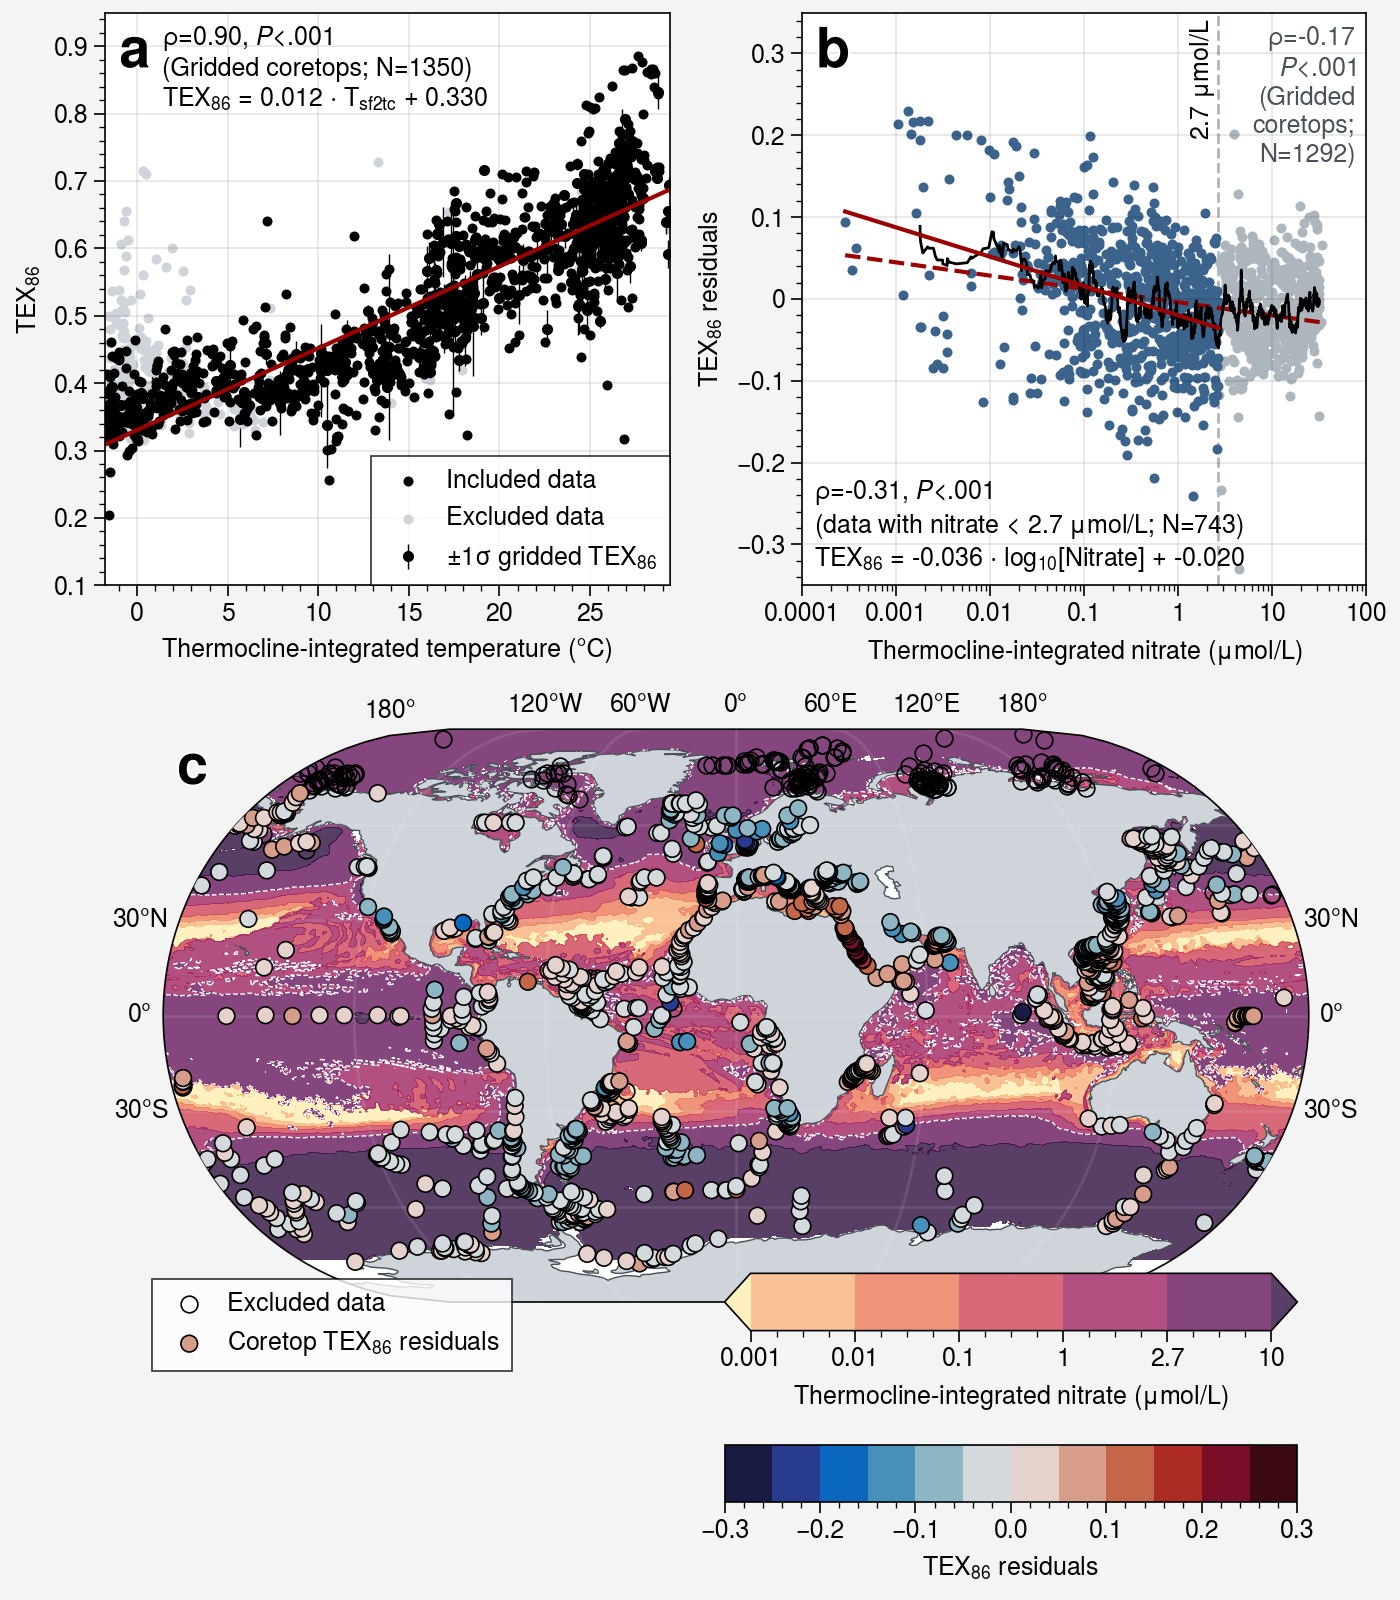

In [29]:
def running_mean_log10(x, y, window_size):
        # Convert x to log10 scale
        log_x = np.log10(x)
        
        # Create a DataFrame with log_x and y
        df = pd.DataFrame({'log_x': log_x, 'y': y})
        
        # Sort the DataFrame by log_x
        df = df.sort_values(by='log_x')
        
        # Calculate the running mean of y with the specified window size
        df['y_running_mean'] = df['y'].rolling(window=window_size, center=True).mean()
        
        return df['log_x'], df['y_running_mean']


plot_coretop = xr.merge([gridded_coretop_ds,t_sf2tc_da]
                        ).to_dataframe().reset_index().dropna(subset=['tex_residuals','t_sf2tc_avg']).reset_index(drop=True)
plot_coretop_no3 = xr.merge([gridded_coretop_ds,thermocline_nitrate_da]
                        ).to_dataframe().reset_index().dropna(subset=['tex_residuals','no3_sf2tc_avg']).reset_index(drop=True)

exclude_coretop = coretop_df[coretop_df['QC_flag']=='exclude']
array = [
    [1,2],
    [3,3]
]
projs = (None,None,'eck3')
fig, axs = plot.subplots(array,proj=projs,
                         figsize=(7,8),
                         share=False,\
                         )



ax = axs[0]
ax.format(
    xlabel='Thermocline-integrated temperature (\N{DEGREE SIGN}C)',
    ylabel='TEX$_{86}$'
)
plot_data = plot_coretop[plot_coretop['lat']<70][['t_sf2tc_avg',
                                                  'tex_median']].dropna().reset_index(drop=True)
plot_x = plot_data['t_sf2tc_avg']
plot_y = plot_data['tex_median']
ax.scatter(plot_x,plot_y,
           m='.',c='k',zorder=2,label='Included data')

plot_err_data = plot_coretop[plot_coretop['lat']<70][['t_sf2tc_avg',
                                                    'tex_median','tex_std']].dropna().reset_index(drop=True)
plot_x_err_data = plot_err_data['t_sf2tc_avg']
plot_y_err_data = plot_err_data['tex_median']
plot_yerr = plot_err_data['tex_std']
ax.errorbar(plot_x_err_data.values,plot_y_err_data.values,
            yerr=plot_yerr.values,
            lw=0.5,
            fmt='.',
            c='k',
            zorder=1,
            capsize=0,
            label='$\\pm$1$\sigma$ gridded TEX$_{86}$')

plot_data = plot_coretop[plot_coretop['lat']>70][['t_sf2tc_avg','tex_median']].dropna()
plot_x = plot_data['t_sf2tc_avg']
plot_y = plot_data['tex_median']
ax.scatter(plot_x,plot_y,
           m='.',c='gray4',zorder=1,
           label='Excluded data')

plot_x = exclude_coretop['thermocline_T_depthIntegral']
plot_y = exclude_coretop['TEX86']
ax.scatter(plot_x,plot_y,m='.',c='gray4',zorder=0,label='')

reg_data = plot_coretop[plot_coretop['lat']<70][['t_sf2tc_avg','tex_median']].dropna()
reg_data2 = reg_data[['t_sf2tc_avg','tex_median']].dropna()
ols_tex_thermoT_thisStudy = LinearRegression()
XX = reg_data2['t_sf2tc_avg']
yy = reg_data2['tex_median']
ols_tex_thermoT_thisStudy.fit(XX.values.reshape(-1,1),yy)
XX_sample = np.linspace(XX.min(),XX.max(),100)
yy_pred = ols_tex_thermoT_thisStudy.predict(XX_sample.reshape(-1,1))
ax.plot(XX_sample,yy_pred,c='deep red')
rho, pval = spearmanr(reg_data2['t_sf2tc_avg'],reg_data2['tex_median'])
### add linear regression equation as text in axs[0]
slope_text = f'{ols_tex_thermoT_thisStudy.coef_[0]:.3f}'
intercept_text = f'{ols_tex_thermoT_thisStudy.intercept_:.3f}'
equation_text = f'TEX$_{{86}}$ = {slope_text} $\cdot$ T$_{{sf2tc}}$ + {intercept_text}'

print(f'r2 score = {ols_tex_thermoT_thisStudy.score(XX.values.reshape(-1,1),yy)}')
pval_label = label_pvalues(pval)
ax.text(0.10,0.98,f'$\\rho$={rho:.2f}, {pval_label}\n(Gridded coretops; N={len(reg_data2)})\n{equation_text}',
        transform=ax.transAxes,
        ha='left',va='top')

h, l = ax.get_legend_handles_labels()
ax.legend(h,l,loc='lr',ncols=1)
ax.format(
        ylim=(0.1,0.95),
)
#########################################################################################
ax = axs[1]

plot_data = plot_coretop_no3[plot_coretop_no3['lat']<70][['no3_sf2tc_avg','tex_residuals']].dropna()
reg_data = plot_data
reg_data['log_thermocl_depthIntg_nitrate'] = np.log10(reg_data['no3_sf2tc_avg'])
reg_data['log_thermocl_depthIntg_nitrate'] = reg_data['log_thermocl_depthIntg_nitrate'].replace([-np.inf,np.inf],np.nan)
ols = LinearRegression()
XX = reg_data['log_thermocl_depthIntg_nitrate']
yy = reg_data['tex_residuals']
ols.fit(XX.values.reshape(-1,1),yy)
XX_sample = np.linspace(XX.min(),XX.max(),100)
yy_pred = ols.predict(XX_sample.reshape(-1,1))
ax.plot(10**XX_sample,yy_pred,c='deep red',ls='--')
rho, pval = spearmanr(reg_data['no3_sf2tc_avg'],reg_data['tex_residuals'])
pval_label = label_pvalues(pval)
ax.text(0.98,0.98,f'$\\rho$={rho:.2f}\n{pval_label}\n(Gridded\ncoretops;\nN={len(reg_data)})',
        transform=ax.transAxes,
        ha='right',va='top',
        c='gray7')

sel_x_param = 'no3_sf2tc_avg'
sel_y_param = 'tex_residuals'
### linear fit between log(nitrate) and TEX residuals
pre_reg_data = plot_data
pre_reg_data = pre_reg_data.sort_values(by=sel_x_param).reset_index(drop=True)

### determine best window size
window_size = np.arange(5,100,1)
score_list = []
for sel_window_size in window_size:
        log_x, y_running_mean = running_mean_log10(pre_reg_data[sel_x_param],pre_reg_data[sel_y_param],sel_window_size)
        lowno3_threshold_tmp = 10**log_x[y_running_mean.idxmin()]
        reg_data = pre_reg_data[pre_reg_data[sel_x_param]<lowno3_threshold_tmp]
        rho, pval = spearmanr(reg_data[sel_x_param],reg_data[sel_y_param])
        score_list.append(rho)
best_window_size = window_size[np.argmin(score_list)]
# best_window_size = 100
print(f'best_window_size = {best_window_size}')
### find x value with minimum running mean of y
log_x, y_running_mean = running_mean_log10(pre_reg_data[sel_x_param],pre_reg_data[sel_y_param],best_window_size)
ax.axvline(10**log_x[y_running_mean.idxmin()],color='gray5',ls='--',lw=1,zorder=0)
lowno3_threshold = np.round(10**log_x[y_running_mean.idxmin()],decimals=1)
ax.text(lowno3_threshold-0.1,0.99,f'{lowno3_threshold:.1f} $\mu$mol/L',transform=ax.get_xaxis_transform(),
        ha='right',va='top',
        rotation=90)
ax.plot(10**log_x,y_running_mean,c='k',lw=1)

plot_x = pre_reg_data[pre_reg_data[sel_x_param]<lowno3_threshold][sel_x_param]
plot_y = pre_reg_data[pre_reg_data[sel_x_param]<lowno3_threshold][sel_y_param]
ax.scatter(plot_x,plot_y,marker='.',color='denim',label='Coretops')


plot_data = plot_coretop_no3[plot_coretop_no3['lat']<70][[sel_x_param,sel_y_param]].dropna()
plot_x_exclude = plot_data[plot_data[sel_x_param]>lowno3_threshold][sel_x_param]
plot_y_exclude = plot_data[plot_data[sel_x_param]>lowno3_threshold][sel_y_param]
ax.scatter(plot_x_exclude,plot_y_exclude,
            marker='.',color='gray5',
            label='Excluded data',zorder=0)

reg_data = pre_reg_data[pre_reg_data[sel_x_param]<lowno3_threshold]

reg_data['log_'+sel_x_param] = np.log10(reg_data[sel_x_param])
reg_data['log_'+sel_x_param] = reg_data['log_'+sel_x_param].replace([-np.inf,np.inf],np.nan)
reg_data = reg_data.dropna(how='any',subset=[sel_x_param,sel_y_param,'log_'+sel_x_param])
ols = sm.OLS(reg_data[sel_y_param],sm.add_constant(reg_data['log_'+sel_x_param])).fit()
plot_x_fit = np.linspace(reg_data['log_'+sel_x_param].min(),reg_data['log_'+sel_x_param].max(),100)
plot_y_fit = ols.predict(sm.add_constant(plot_x_fit))
ax.plot(10**plot_x_fit,plot_y_fit,c='deep red',
        label='TEX residuals')

### print regression equation
slope_text = f'{ols.params[1]:.3f}'
intercept_text = f'{ols.params[0]:.3f}'
equation_text = f'TEX$_{{86}}$ = {slope_text} $\cdot$ log$_{{10}}$[Nitrate] + {intercept_text}'

rho, pval = spearmanr(reg_data[sel_x_param],reg_data[sel_y_param])
pval_label = label_pvalues(pval)
ax.text(0.02,0.02,
        f'$\\rho$={rho:.2f}, {pval_label}\n(data with nitrate < {lowno3_threshold:.1f} $\mu$mol/L; N={len(reg_data)})\n{equation_text}',
        transform=ax.transAxes,
        ha='left',va='bottom')



ax.format(
    xscale='log',
    xlim=(1e-4,1e2),
    ylim=(-0.35,0.35),
    xlabel='Thermocline-integrated nitrate ($\mu$mol/L)',
    ylabel='TEX$_{86}$ residuals'
)
#########################################################################################
ax = axs[2]
ax.format(land=True, landcolor='gray4',landzorder=0,
        latlabels='lr', lonlabels='top',
        gridcolor='w',gridlinewidth=1,
        latlocator=[-60,-30,0,30,60],
        coast=True, coastcolor='gray7',
        coastlinewidth=0.5,
        coastzorder=1,)
##### plot a contour line of thermocline-integrated nitrate at lowno3_threshold μM
m = thermocline_nitrate_da.plot.contourf(ax=ax,levels=[1e-3,1e-2,1e-1,1,lowno3_threshold,10],
                                        cmap='matter',alpha=0.8,
                                        add_colorbar=False,robust=True,
                                        label=None,rasterized=True)

axins1 = inset_axes(
    ax,
    width="50%",
    height="10%",
    loc="lower right",
    bbox_to_anchor=(-0.01,-0.05,1,1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)

axins1.patch.set_alpha(0)
cbar = fig.colorbar(m,
             cax=axins1,
             orientation="horizontal",
             label='Thermocline-integrated nitrate ($\mu$mol/L)',
             )
axins1.xaxis.set_ticklabels(['0.001','0.01','0.1','1',f'{lowno3_threshold}','10'])

thermocline_nitrate_da.plot.contour(ax=ax,levels=[0,lowno3_threshold],
                                                 linewidths=0.5,
                                                 linestyles='dashed',
                                                 colors='w',robust=True)

ax.set_title('')
###### plot tex residuals on map

plot_x = exclude_coretop['Longitude']
plot_y = exclude_coretop['Latitude']
ax.scatter(plot_x,plot_y,m='o',mec='k',facecolor='none',zorder=2)

plot_data = plot_coretop[plot_coretop['lat']>70][['lon','lat','tex_median']].dropna(subset=['tex_median'])
plot_x = plot_data['lon']
plot_y = plot_data['lat']
ax.scatter(plot_x,plot_y,
           m='o',mec='k',facecolor='none',zorder=2,
           label='Excluded data')

plot_data = plot_coretop[plot_coretop['lat']<70][['lon','lat','tex_residuals']].dropna()
plot_x = plot_data['lon']
plot_y = plot_data['lat']
plot_c = plot_data['tex_residuals']
m=ax.scatter(plot_x,plot_y,
           c=plot_c,mec='k',
           levels=np.arange(-0.3,0.31,0.05),
           transform=ccrs.PlateCarree(),
           m='o',cmap='Balance',
           label='Coretop TEX$_{86}$ residuals',
           zorder=3)

h,l = ax.get_legend_handles_labels()

ax.legend(h[1:],l[1:],loc='lower left',
          bbox_to_anchor=(-0.01,-0.12,1,1),
          ncols=1)

axins1 = inset_axes(
    ax,
    width="50%",
    height="10%",
    loc="lower right",
    bbox_to_anchor=(-0.01,-0.35,1,1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
cbar = fig.colorbar(m,
             cax=axins1,
             orientation="horizontal",
             label='TEX$_{86}$ residuals'
             )




#########################################################################################
axs.format(abc=True,abcloc='ul',abcstyle='a',rc_kw={'abc.size':20},)


fpath = fr'{local_github_path}/figures/'
fname = 'gridded_coretops_regression_nitrate_effect_global.pdf'
fig.savefig(os.path.join(fpath,fname),bbox_inches='tight',embed_fonts=True,dpi=660)

## Fig. 2: Regional nutrient effects

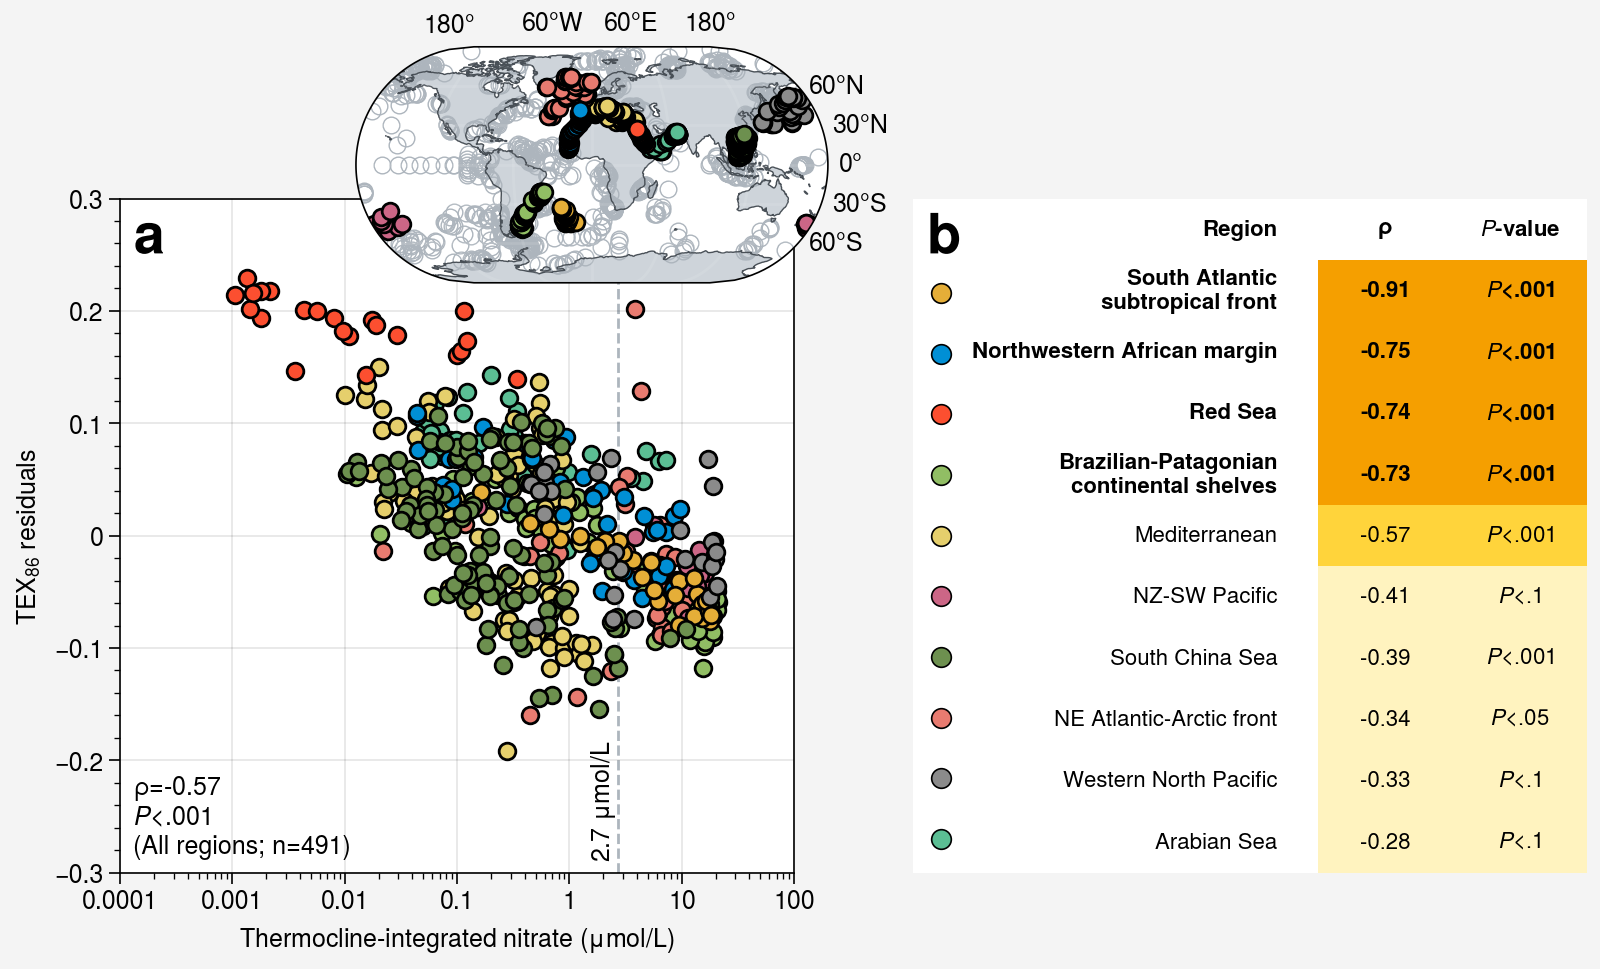

In [30]:
# array = [
#     [1,1,2,2],
#     [1,1,2,2]
# ]
cyc1 = plot.get_colors('qual1',N=5)
cyc2 = plot.get_colors('538',N=5)

sel_cyc = plot.Cycle(cyc1+cyc2)
### param for plotting
optimal_pval_cutoff = 0.1
nitrate_cutoff = 100

fig, axs = plot.subplots(ncols=2,
                         share=0,
                         width=8)

plot_data = xr.merge([gridded_coretop_ds,t_sf2tc_da,thermocline_nitrate_da,coretop_gridded_d15N_ds])
plot_gridded_data = plot_data[['lat','lon','t_sf2tc_avg','no3_sf2tc_avg',
                                'tex_median','tex_residuals','tex_std',
                                'd15N_mean','region_ID']].to_dataframe().dropna(subset=['region_ID']).reset_index()
plot_gridded_data['regionName'] = plot_gridded_data['region_ID'].map(regionID_to_regionName_dict)
plot_gridded_data['regionName'] = plot_gridded_data['regionName'].replace({
    'Eastern Indian Ocean (Offshore Indonesia)' : 'Indonesian Offshore',
    'Northern Pacific':'Western North Pacific',
    'Eastern South America Offshore':'Brazilian-Patagonian\ncontinental shelves',
    'South Atlantic Gyre':'South Atlantic\nsubtropical front',
    'Tropical West African Offshore':'Northwestern African margin',
    'North Atlantic':'NE Atlantic-Arctic front',
})

plot_gridded_data = plot_gridded_data[plot_gridded_data['no3_sf2tc_avg']<nitrate_cutoff]

# Create an inset axis overlapping on the top right corner of axs[0]
ax_inset = axs[0].inset_axes([0.35, 0.7, 0.7, 0.7],proj='eck3')

ax_inset.format(land=True, landcolor='gray4',landzorder=0,
        latlabels='r', lonlabels='top',
        gridcolor='w',gridlinewidth=1,
        latlocator=[-60,-30,0,30,60],
        coast=True, coastcolor='gray7',
        coastlinewidth=0.5,
        coastzorder=1,)
grouped = plot_gridded_data.groupby('regionName')

#### calculate rho and pval between tex_residuals and thermocl_depthIntg_nitrate by regions
rho_list = []
pval_list = []
region_name_list = []
for name, group in grouped:
    reg_data = group[['no3_sf2tc_avg', 'tex_residuals']].dropna()
    if len(reg_data) < 10:
        continue
    else:
        rho, pval = spearmanr(reg_data['no3_sf2tc_avg'], reg_data['tex_residuals'])
        rho_pearson, pval_pearson = pearsonr(reg_data['no3_sf2tc_avg'], reg_data['tex_residuals'])
        region_name_list.append(name)
        rho_list.append(rho)
        pval_list.append(pval)

### build a dataframe to sort by rho
rho_df = pd.DataFrame({'regionName': region_name_list,
                       'rho': rho_list,
                       'pval': pval_list})

sig_regions_ = rho_df[((rho_df['pval'] < optimal_pval_cutoff)
                       & (rho_df['rho'] < 0))]

sig_regions_ = rho_df[((rho_df['pval'] < optimal_pval_cutoff)
                       & (rho_df['rho'] < 0))][rho_df['regionName'].isin([
                           'Weddell Sea', 'Arctic Ocean', 'Drake Passage',
                           'Kara Sea', 'Greenland Sea',
                           'Laptev Sea',
                           'Sea of Okhotsk',
                        #    'Eastern South America Offshore_far'
                           ]) == False]
sig_regions_color_dict = dict(zip(sig_regions_['regionName'], plot.get_colors(sel_cyc, N=len(sig_regions_))))

for name, group in grouped:
    ### check rho and pval of each region
    if name not in sig_regions_['regionName'].unique():
        ax_inset.scatter(group['lon'], group['lat'],
                         c='none',
                         mec='gray5', mew=0.5,
                         label=name,
                         zorder=1)
    else:
        rho_ = rho_df[rho_df['regionName'] == name]['rho'].values[0]
        pval_ = rho_df[rho_df['regionName'] == name]['pval'].values[0]

        if (pval_ < optimal_pval_cutoff
            and (rho_ < 0)
            and name != 'Weddell Sea'
            and name != 'Arctic Ocean'
            and name != 'Drake Passage'
            and name != 'Kara Sea'
            and name != 'Greenland Sea'
            and name != 'Laptev Sea'
            and name != 'Sea of Okhotsk'
            # and name != 'Eastern South America Offshore_far'
            ):
            ax_inset.scatter(group['lon'], group['lat'],
                            #  cycle=sel_cyc,
                             c=sig_regions_color_dict.get(name, 'gray5'),
                             mec='k', mew=1,
                             label=name,
                             zorder=2)
            
ax = axs[0]
sig_plot_data = plot_gridded_data[plot_gridded_data['regionName'].isin(sig_regions_['regionName'])]
grouped = sig_plot_data.groupby('regionName')   
for name, group in grouped:
    ### plot data
    ax.scatter(group['no3_sf2tc_avg'],group['tex_residuals'],
                cycle=sel_cyc,
                mec='k',mew=1,
                label=name,
                zorder=2)
    
### add low-nitrate threshold
ax.axvline(lowno3_threshold,color='gray5',ls='--',lw=1,zorder=0)
### add vertical text 
x_pos = lowno3_threshold
y_pos = -0.29
ax.text(x_pos,y_pos,f'{lowno3_threshold:.1f} $\mu$mol/L',
        # transform=ax.get_xaxis_transform(),
        ha='right',va='bottom',
        rotation=90)
    
### ols regression of all significant regions
reg_data = sig_plot_data[['no3_sf2tc_avg','tex_residuals']].dropna()
reg_data['Log10_nitrate'] = np.log10(reg_data['no3_sf2tc_avg'])
ols = LinearRegression()
XX = reg_data['Log10_nitrate']
yy = reg_data['tex_residuals']
ols.fit(XX.values.reshape(-1,1),yy)
XX_sample = np.linspace(XX.min(),XX.max(),100)
yy_pred = ols.predict(XX_sample.reshape(-1,1))
# ax.plot(10**XX_sample,yy_pred,c='deep red')
### spearman rho and pval
rho, pval = spearmanr(reg_data['no3_sf2tc_avg'],reg_data['tex_residuals'])
pval_label = label_pvalues(pval)
ax.text(0.02,0.02,f'$\\rho$={rho:.2f}\n{pval_label}\n(All regions; n={len(reg_data)})',
        transform=ax.transAxes,
        ha='left',va='bottom')

### orthoganal distance regression 
X = reg_data['Log10_nitrate']
y = reg_data['tex_residuals']
covx = np.cov(X)
covy = np.cov(y)
odr_dat = scipy.odr.Data(X,y)
def linear_func(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]
odr_func = scipy.odr.Model(linear_func)
odr = scipy.odr.ODR(odr_dat,odr_func,beta0=[-2.,0.2])
out = odr.run()
slope = out.beta[0]
intercept = out.beta[1]
X_pred = np.linspace(X.min(),X.max(),100)
y_pred = linear_func(out.beta,X_pred)
# ax.plot(10**X_pred,y_pred,c='k',ls='--',lw=2,label='ODR fit')

ax.format(
    xlabel='Thermocline-integrated nitrate ($\mu$mol/L)',
    ylabel='TEX$_{86}$ residuals',
    xlim=(1e-4,1e2),
    xscale='log',
    ylim=(-0.3,0.3),
)


axs.format(
    abc=True,abcstyle='a',rc_kw={'abc.size':20},abcloc='ul',
)

### plot a table reporting rho and pval of significant regions
table_ax = axs[1]
table_ax.axis('off')
table_data = sig_regions_[['regionName','rho','pval']]

### formatted values to be displayed in the table as 4 significant figures
table_data['rho'] = table_data['rho'].apply(lambda x: f'{x:.2f}')
table_data['pval'] = table_data['pval'].apply(lambda x: f'{x:.4f}')
table_data['pval_labels'] = table_data['pval'].apply(lambda x: label_pvalues(float(x)))
table_data = table_data.rename(columns={'regionName':'Region',
                                        'rho':'$\\rho$',
                                        'pval_labels':r'$\it{P}$-value'})


table_data2 = table_data[['Region','$\\rho$',r'$\it{P}$-value']].sort_values(by='$\\rho$',ascending=False).copy()
### color cell with rho < -0.7
### set header text bold
### set header background color
# Define the number of rows and columns in the table
num_rows, num_cols = table_data2.shape

# Create a list for cell colors, keeping the first column (Region) white
cell_colors = [['white'] * num_cols for _ in range(num_rows)]

# Apply colors only to the second and third columns based on rho values
for i, rho in enumerate(table_data2['$\\rho$']):
    rho_value = float(rho)
    color = (
        'yellow7' if rho_value < -0.7 else 
        'yellow4' if rho_value < -0.5 else 
        'yellow1'
    )
    cell_colors[i][1] = color  # Apply color to the rho column
    cell_colors[i][2] = color  # Apply the same color to the p-value column

table = table_ax.table(cellText=table_data2.values,
                colLabels=table_data2.columns,
                loc='top',
                bbox=[0,0,1,1],
                colWidths=[0.6,0.2,0.2],
                cellColours=cell_colors,
                )

# Style table text
for (row, col), cell in table.get_celld().items():
    if row == 0:  # Header row
        cell.get_text().set_fontweight('bold')
    if col == 0:
        cell.get_text().set_ha('right')  # Align first column to the right
        if row > 0:
            region_name = table_data2.iloc[row-1]['Region'][2:]  
    else:
        cell.get_text().set_ha('center')
        if col == 1 and row > 0:
            if float(cell.get_text().get_text()) < -0.7:
                table[(row, 0)].get_text().set_fontweight('bold')
                table[(row, 1)].get_text().set_fontweight('bold')                
                table[(row, 2)].get_text().set_fontweight('bold')
    
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.5, 1.5)
#change table line color to white
for key, cell in table.get_celld().items():
    cell.set_linewidth(0)

# Add colored markers manually using scatter()
num_rows = len(table_data2)
x_offset = -0.15  # Adjust this to position the circles
y_offset = np.linspace(0.86, 0.05, num_rows)  # Evenly space markers in the column

for i, region in enumerate(table_data2['Region']):
    color = sig_regions_color_dict.get(region, 'black')  # Default to black if not found
    table_ax.scatter(x_offset, y_offset[i], color=color, s=50, edgecolor='k', zorder=3)
    


table_ax.set_xlim(-0.2, 1)  # Adjust limits to ensure markers are visible
table_ax.set_ylim(0, 1)

fpath = fr'{local_github_path}/figures/'
fname = 'gridded_regional_nitrate_effect_sig_regions.pdf'
fig.savefig(os.path.join(fpath,fname),bbox_inches='tight',embed_fonts=True,dpi=1440)

In [31]:
### round rho to 2 decimal places and pval to 4 decimal places
rho_df['rho_labels'] = rho_df['rho'].apply(lambda x: f'{x:.2f}')
rho_df['pval_labels'] = rho_df['pval'].apply(lambda x: f'{x:.4f}')
rho_df[rho_df['rho']<0].sort_values(by='pval')[['regionName','rho_labels','pval_labels']]

,regionName,rho_labels,pval_labels
7,Brazilian-Patagonian\ncontinental shelves,-0.73,0.0000
30,South Atlantic\nsubtropical front,-0.91,0.0000
24,Northwestern African margin,-0.75,0.0000
19,Mediterranean,-0.57,0.0000
31,South China Sea,-0.39,0.0000
26,Red Sea,-0.74,0.0001
10,Drake Passage,-0.39,0.0111
36,Weddell Sea,-0.68,0.0153
21,NE Atlantic-Arctic front,-0.34,0.0324
2,Arctic Ocean,-0.49,0.0664


## Fig. 3: Paleo case study - Arabian Sea

In [32]:
fpath = fr'{local_github_path}/spreadsheets/published_data'
fname = 'Seierstad2014_NGRIP_d18O_dataset.xlsx'

### data sheet name is "4) d18O and Ca 50 yrs mean"
### data starts from line 6
### header is in line 4
ngrip_df = pd.read_excel(os.path.join(fpath,fname),sheet_name="3) d18O and Ca 20 yrs mean",skiprows=51)

### grab column names from line 4 in the excel sheet
header = pd.read_excel(os.path.join(fpath,fname),sheet_name="3) d18O and Ca 20 yrs mean",skiprows=49)
header = header.iloc[0,:].values

### add column names to dataframe
ngrip_df.columns = header
ngrip_df = ngrip_df[ngrip_df['Age']<20000]
ngrip_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1997 entries, 0 to 1996
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            1997 non-null   int64  
 1   NGRIP1 depth   980 non-null    float64
 2   d18O NGRIP1    980 non-null    float64
 3   NGRIP2 depth   1045 non-null   float64
 4   d18O NGRIP2    1045 non-null   float64
 5   [Ca2+] NGRIP2  965 non-null    float64
 6   GRIP depth     1997 non-null   float64
 7   d18O GRIP      1997 non-null   float64
 8   [Ca2+] GRIP    1201 non-null   float64
 9   GISP2 depth    1989 non-null   float64
 10  d18O GISP2     1951 non-null   float64
 11  [Ca2+] GISP2   1989 non-null   float64
 12  MCE            1997 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 218.4 KB


In [33]:
import bayspline as bsl

#### read data from tab file to pandas dataframe; data starts after the last line with */

fpath = fr'{local_github_path}/spreadsheets/published_data/Huguet2006_ArabianSea_paleorecords'
fname = 'SO42-74KL_SST.tab'

with open(os.path.join(fpath,fname),'r') as f:
    lines = f.readlines()
    
for i,line in enumerate(lines):
    if line.startswith('*/'):
        break
# header = lines[i+1].split()
data = lines[i+2:]
data = [line.split() for line in data]
df = pd.DataFrame(data,columns=['Age_kaBP','SST_UK37','SST_TEX86'])
SO42_75KL_SST_df = df.apply(pd.to_numeric,errors='ignore')
SO42_75KL_SST_df['uk37'] = 0.033*SO42_75KL_SST_df['SST_UK37']+0.044
SO42_75KL_SST_df['sst'] = bsl.predict_sst(SO42_75KL_SST_df['uk37'], prior_std=10).percentile(50)
SO42_75KL_SST_df

100%|██████████| 500/500 [00:06<00:00, 72.84it/s]


,Age_kaBP,SST_UK37,SST_TEX86,uk37,sst
0,0.2000,27.3000,26.3900,0.9449,28.5377
1,0.4000,27.3600,27.4700,0.9469,28.6025
2,0.6000,27.2700,27.1300,0.9439,28.4117
3,0.8200,27.3600,26.8200,0.9469,28.6062
4,1.0300,27.1200,27.8100,0.9390,28.1240
...,...,...,...,...,...
71,20.2900,25.1200,25.2100,0.8730,24.7759
72,20.9000,24.8500,23.9300,0.8641,24.4039
73,21.5000,25.0900,23.7800,0.8720,24.7504
74,22.1100,25.1500,25.0200,0.8740,24.8274


In [34]:
#### read data from tab file to pandas dataframe; data starts after the last line with */

fpath = fr'{local_github_path}/spreadsheets/published_data/Huguet2006_ArabianSea_paleorecords'
fname = 'NIOP-C2_905_PC_SST.tab'

with open(os.path.join(fpath,fname),'r') as f:
    lines = f.readlines()
    
for i,line in enumerate(lines):
    if line.startswith('*/'):
        break
# header = lines[i+1].split()
data = lines[i+2:]
data = [line.split() for line in data]
df = pd.DataFrame(data,columns=['Age_kaBP','SST_UK37','SST_TEX86'])
NIOP905_SST_df = df.apply(pd.to_numeric,errors='ignore')
NIOP905_SST_df ['uk37'] = 0.033*NIOP905_SST_df['SST_UK37']+0.044
NIOP905_SST_df ['sst'] = bsl.predict_sst(NIOP905_SST_df['uk37'], prior_std=10).percentile(50)
NIOP905_SST_df

100%|██████████| 500/500 [00:07<00:00, 68.84it/s]


,Age_kaBP,SST_UK37,SST_TEX86,uk37,sst
0,0.0190,26.3000,25.7100,0.9119,26.6182
1,0.2080,26.3300,26.2400,0.9129,26.6535
2,0.3970,26.3300,25.7900,0.9129,26.6653
3,0.5860,26.4900,26.0900,0.9182,26.9243
4,0.7820,26.4200,26.4200,0.9159,26.8535
...,...,...,...,...,...
106,21.9060,25.0900,22.5900,0.8720,24.7263
107,22.1640,25.4900,22.4700,0.8852,25.3485
108,22.4220,25.3900,NaN,0.8819,25.1518
109,22.6800,25.7700,NaN,0.8944,25.7207


In [35]:
NIOP905_SST_df

,Age_kaBP,SST_UK37,SST_TEX86,uk37,sst
0,0.0190,26.3000,25.7100,0.9119,26.6182
1,0.2080,26.3300,26.2400,0.9129,26.6535
2,0.3970,26.3300,25.7900,0.9129,26.6653
3,0.5860,26.4900,26.0900,0.9182,26.9243
4,0.7820,26.4200,26.4200,0.9159,26.8535
...,...,...,...,...,...
106,21.9060,25.0900,22.5900,0.8720,24.7263
107,22.1640,25.4900,22.4700,0.8852,25.3485
108,22.4220,25.3900,NaN,0.8819,25.1518
109,22.6800,25.7700,NaN,0.8944,25.7207


In [36]:
slope = ols_tex_thermoT_thisStudy.coef_[0]
intercept = ols_tex_thermoT_thisStudy.intercept_

fpath = fr'{local_github_path}/spreadsheets/published_data'
fname = 'PhanSST_v001.csv'
PhanSST_df = pd.read_csv(os.path.join(fpath,fname))
PhanTEX_df = PhanSST_df[PhanSST_df['ProxyType']=='tex'].reset_index(drop=True)

NIOP905_tex_df = PhanSST_df[PhanSST_df['SiteName']=='NIOP-C2_905_PC'].reset_index(drop=True)
NIOP905_tex_df['SST'] = (NIOP905_tex_df['ProxyValue'] - intercept)/slope

SO42_75KL_tex_df = PhanSST_df[PhanSST_df['SiteName']=='SO42-74KL'].reset_index(drop=True)
SO42_75KL_tex_df['SST'] = (SO42_75KL_tex_df['ProxyValue'] - intercept)/slope

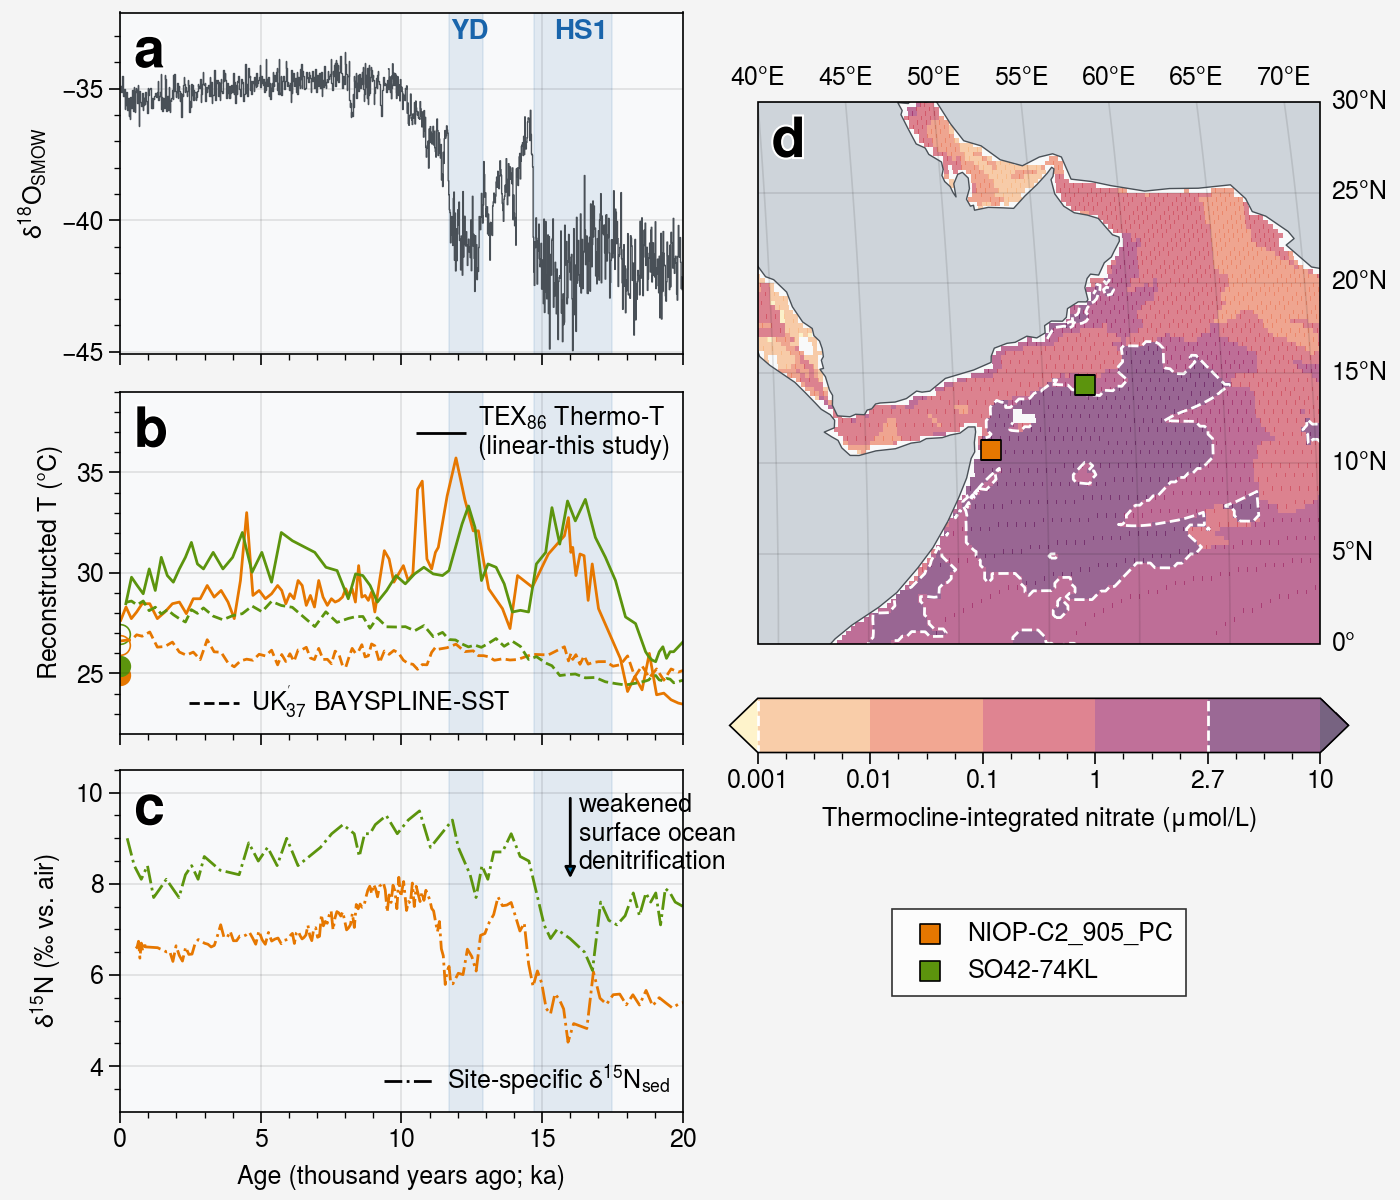

In [37]:
array = [
    [1,1,4,4],
    [2,2,4,4],
    [3,3,0,0],
]
fig, axs = plot.subplots(
    array,
    figsize=(7,6),
    sharey=0,
    wspace=3,
    proj=(None,None,None,'eck3')
    )

axs.format(facecolor='gray0')
########## site locations
ax = axs[3]
ax.format(land=True,landcolor='gray4',landzorder=0,
          coast=True,coastcolor='gray7',coastlinewidth=0.5,
          latlim=(0,30),lonlim=(40,70),
          latlabels='r',lonlabels='t',)


### lat lon for NIOP-C2_905_PC = 10.767N,51.95E
### lat lon for SO42-74KL = 14.321N, 57.347E
ax.scatter(51.95,10.767,c='yellow9',
           mec='k',marker='s',s=50,
           label='NIOP-C2_905_PC',
           zorder=2)
ax.scatter(57.347,14.321,c='lime9',
           mec='k',marker='s',s=50,
           label='SO42-74KL',
           zorder=2)

### plot sst and thermoT of modern sst for two core locations
NIOP905_today_sst = T_da.isel(depth=0).sel(lat=10.767,lon=51.95,method='nearest').values
axs[1].scatter(0,NIOP905_today_sst,facecolor='none',mec='yellow9',marker='o',s=50,)
NIOP905_today_thermoT = t_sf2tc_da.sel(lat=10.767,lon=51.95,method='nearest').values
axs[1].scatter(0,NIOP905_today_thermoT,c='yellow9',marker='o',s=50,)

SO42_today_sst = T_da.isel(depth=0).sel(lat=14.321,lon=57.347,method='nearest').values
axs[1].scatter(0,SO42_today_sst,facecolor='none',mec='lime9',marker='o',s=50,)
SO42_today_thermoT = t_sf2tc_da.sel(lat=14.321,lon=57.347,method='nearest').values
axs[1].scatter(0,SO42_today_thermoT,c='lime9',marker='o',s=50,)

### plot modern d15N for arabian sea regions

plot_data = coretop_gridded_d15N_ds.sel(lat=slice(10,20),
                                        lon=slice(50,60)
                                        ).to_dataframe().dropna(subset=['d15N_mean']).reset_index()

m=thermocline_nitrate_da.sel(lat=slice(-10,30),lon=slice(25,90)).plot(ax=ax,
                                                                    zorder=0,
                                                                    levels=[1e-3,1e-2,1e-1,1,lowno3_threshold,10],
                                                                    cmap='matter',
                                                                    add_colorbar=False,
                                                                    alpha=0.65,
                                                                    rasterized=True)
ax.set_title('')
### plot the lowno3_threshold μM contour line
m2=thermocline_nitrate_da.sel(lat=slice(-10,30),lon=slice(25,90)
                                       ).plot.contour(ax=ax,levels=[0,lowno3_threshold],
                                                        zorder=1,
                                                        linewidths=1,
                                                        linestyles='dashed',
                                                        colors='w',robust=True)

axins1 = inset_axes(
    ax,
    width="110%",
    height="10%",
    loc="lower center",
    bbox_to_anchor=(0,-0.2,1,1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)

axins1.patch.set_alpha(0)
cbar = fig.colorbar(m,
             cax=axins1,
             orientation="horizontal",
             label='Thermocline-integrated nitrate ($\mu$mol/L)',
             extend='both'
             )
cbar.add_lines(m2)
cbar.lines[0].set_linestyle('dashed')
axins1.xaxis.set_ticklabels(['0.001','0.01','0.1','1',f'{lowno3_threshold}','10'])

###### time series plot
ax = axs[0]
ax.format(
    ylabel='$\delta^{18}$O$_{SMOW}$',
)
plot_data = ngrip_df.dropna(how='all',subset=['d18O NGRIP1']).reset_index(drop=True)
plot_x = plot_data['Age']/1000
plot_y = plot_data['d18O NGRIP1']
ax.plot(plot_x,plot_y,c='gray7',lw=0.5,label='NGRIP')

plot_data = ngrip_df.dropna(how='all',subset=['d18O NGRIP2']).reset_index(drop=True)
plot_x = plot_data['Age']/1000
plot_y = plot_data['d18O NGRIP2']
ax.plot(plot_x,plot_y,c='gray7',lw=0.5,label='')


ax = axs[1]
ax.format(
    ylabel='Reconstructed T ($\degree$C)',
)
plot_data = NIOP905_SST_df
plot_x = plot_data['Age_kaBP']
plot_y = plot_data['sst']
ax.plot(plot_x,plot_y,c='yellow9',ls='--',lw=1)

plot_data = NIOP905_tex_df
plot_x = plot_data['Age']*1000
plot_y2 = plot_data['SST']
ax.plot(plot_x,plot_y2,c='yellow9',lw=1)

plot_data = SO42_75KL_SST_df 
plot_x = plot_data['Age_kaBP']
plot_y = plot_data['sst']
ax.plot(plot_x,plot_y,c='lime9',ls='--',lw=1)

plot_data = SO42_75KL_tex_df
plot_x = plot_data['Age']*1000
plot_y2 = plot_data['SST']
ax.plot(plot_x,plot_y2,c='lime9',lw=1)

#### plotting d15N data


ax = axs[2]
ax.format(
    ylabel='$\delta^{15}$N (‰ vs. air)',
    ylim=(3,10.5)
)
    
#### add an arrow with annotation showing reduced denitrification during YD and HS1
ax.annotate('',
            xy=(16,10),xytext=(16,8),
            arrowprops=dict(arrowstyle='<|-',lw=1),
            ha='center',va='center',fontsize=8)
ax.text(16.3,10,'weakened\nsurface ocean\ndenitrification',
        ha='left',va='top',fontsize=9)

sel_sites = ['NIOP 905','SO42-74KL']
sel_colors = ['yellow9','lime9']
plot_data = downcore_d15N_df[downcore_d15N_df['core_name'].isin(sel_sites)].dropna(subset=['Age','d15N'])
grouped = plot_data.groupby('core_name')
for name, group in grouped:
    group = group.sort_values(by='Age').reset_index(drop=True)
    plot_x = group['Age']
    plot_y = group['d15N']
    ax.plot(plot_x,plot_y,
            c=sel_colors[sel_sites.index(name)],
            lw=1,ls='-.',label='site-specific $\delta^{15}$N$_{sed}$')

#### add shaded area highlighting Younger Dryas (YD; 12.9-11.7 ka) and Heinrich stadial 1 (HS1; 16.9-14.5 ka) for all plots
for ax in axs[:3]:
    ax.axvspan(11.7,12.9,color='blue9',alpha=0.1)
    ax.axvspan(14.7,17.5,color='blue9',alpha=0.1)
### add text labels for YD and HS1 at the top of subplot A
ax = axs[0]
ax.text(0.62,0.98,'YD',transform=ax.transAxes,
        ha='center',va='top',color='blue9',
        fontsize=10,fontweight='bold')
ax.text(0.82,0.98,'HS1',transform=ax.transAxes,
        ha='center',va='top',color='blue9',
        fontsize=10,fontweight='bold')



############################################################

h, l = axs[1].get_legend_handles_labels()
h2, l2 = axs[2].get_legend_handles_labels()
h3,l3 = axs[-1].get_legend_handles_labels()


axs[1].legend(h[1],loc='ur',c='k',
              frameon=False,
              ncols=1,
              bbox_to_anchor=(0,0,1,1),
              labels=['TEX$_{86}$ Thermo-T\n(linear-this study)'],
              fontsize=8,
              )
axs[1].legend(h[0],loc='ll',c='k',
              frameon=False,
              ncols=1,
              bbox_to_anchor=(0.1,0,1,1),
              labels=["UK$^{'}_{37}$ BAYSPLINE-SST"],
              fontsize=8,
              )


axs[2].legend([h2[i] for i in [1]],
              loc='lr',ncols=1,
              c='k',
              frameon=False,
              labels=['Site-specific $\delta^{15}$N$_{sed}$']
              )

axs[-1].legend(h3,loc='lower center',ncol=1,
               bbox_to_anchor=(0,-0.65,1,1),
               labels=['NIOP-C2_905_PC','SO42-74KL'],)


## set the color for the first two marker elements as black

axs.format(
    abc=True,abcloc='ul',abcstyle='a',rc_kw={'abc.size':20},
    xlim=(0,20),
    xlabel='Age (thousand years ago; ka)',
)

### set ylims for each plot
axs[0].format(ylim=(-45.1,-32.1),yticks=[-45,-40,-35])
axs[1].set_ylim(22,39)
plt.show()

fpath = fr'{local_github_path}/figures/'
fname = 'paleo_showcase_ArabianSea.pdf'
fig.savefig(os.path.join(fpath,fname),bbox_inches='tight',embed_fonts=True,dpi=1440)

## Fig. 4: Paleo case study - Tasman Sea

In [38]:
fpath = fr'{local_github_path}/spreadsheets/'
fname = 'ds07_TasmanSea_paleorecords.xlsx'

slope = ols_tex_thermoT_thisStudy.coef_[0]
intercept = ols_tex_thermoT_thisStudy.intercept_

#################
DSDP591_uk37_df = pd.read_excel(os.path.join(fpath,fname),sheet_name='DSDP591_Alkenone_Data',skiprows=4)
## header is in line 3 of the excel sheet
header = pd.read_excel(os.path.join(fpath,fname),sheet_name='DSDP591_Alkenone_Data',skiprows=2).iloc[0,:].values
DSDP591_uk37_df.columns = header
DSDP591_uk37_df = DSDP591_uk37_df.rename(columns={'Mid Depth':'Depth_mbsf',
                                                  'Age 1':'Age_ka',
                                                  'Age 2':'Age2_ka',
                                                  "UK37'":'uk37',
                                                  'BAYSPLINE-derived SST':'SST_bayspline',
                                                  "UK37 Total":'uk37_conc_ng_g'})
features = ['Depth_mbsf','Age_ka','uk37','SST_bayspline','uk37_conc_ng_g']
DSDP591_uk37_df = DSDP591_uk37_df[features].dropna(subset=['uk37','SST_bayspline','uk37_conc_ng_g'])
display(DSDP591_uk37_df.head())

#################
DSDP591_tex86_df = pd.read_excel(os.path.join(fpath,fname),sheet_name='DSDP591_GDGT_Data',skiprows=4)
## header is in line 3 of the excel sheet
header = pd.read_excel(os.path.join(fpath,fname),sheet_name='DSDP591_GDGT_Data',skiprows=2).iloc[0,:].values
DSDP591_tex86_df.columns = header
DSDP591_tex86_df = DSDP591_tex86_df.rename(columns={'Mid Depth':'Depth_mbsf',
                                                  'Age 1':'Age_ka',
                                                  'Age 2':'Age2_ka',})
DSDP591_tex86_df['sst_new'] = (DSDP591_tex86_df['TEX86']-intercept)/slope
display(DSDP591_tex86_df.head())

#################
IODPU1510_uk37_df = pd.read_excel(os.path.join(fpath,fname),sheet_name='IODPU1510_Alkenone_Data',skiprows=4)
## header is in line 3 of the excel sheet
header = pd.read_excel(os.path.join(fpath,fname),sheet_name='IODPU1510_Alkenone_Data',skiprows=2).iloc[0,:].values
IODPU1510_uk37_df.columns = header
IODPU1510_uk37_df = IODPU1510_uk37_df.rename(columns={'Mid Depth':'Depth_mbsf',
                                                  'Age 1':'Age_ka',
                                                  'Age 2':'Age2_ka',
                                                  "UK37'":'uk37',
                                                  'BAYSPLINE-derived SST':'SST_bayspline',
                                                  "UK37 Total":'uk37_conc_ng_g'})
features = ['Depth_mbsf','Age_ka','uk37','SST_bayspline','uk37_conc_ng_g']
IODPU1510_uk37_df = IODPU1510_uk37_df[features].dropna(subset=['uk37','SST_bayspline','uk37_conc_ng_g'])
display(IODPU1510_uk37_df.head())

################
IODPU1510_tex86_df = pd.read_excel(os.path.join(fpath,fname),sheet_name='IODPU1510_GDGT_Data',skiprows=4)
## header is in line 3 of the excel sheet
header = pd.read_excel(os.path.join(fpath,fname),sheet_name='IODPU1510_GDGT_Data',skiprows=2).iloc[0,:].values
IODPU1510_tex86_df.columns = header
IODPU1510_tex86_df = IODPU1510_tex86_df.rename(columns={'Mid Depth':'Depth_mbsf',
                                                  'Age 1':'Age_ka',
                                                  'Age 2':'Age2_ka',})
IODPU1510_tex86_df['sst_new'] = (IODPU1510_tex86_df['TEX86']-intercept)/slope
display(IODPU1510_tex86_df.head())


,Depth_mbsf,Age_ka,uk37,SST_bayspline,uk37_conc_ng_g
1,0.0800,3.7333,0.7803,21.5670,60.1421
2,0.1300,6.0667,0.7821,21.6121,55.2160
3,0.1500,7.0000,0.7784,21.5189,42.3467
4,0.2100,9.8000,0.7586,20.9047,51.5504
5,0.2600,12.1333,0.7519,20.7060,51.6537


,Leg/Exp,Site,Hole,Core,Type,Section,Interval top,Interval bottom,Depth_mbsf,NaN,...,BIT,MI,%GDGT-0,GDGT-0/Cren,GDGT-2/Cren,GDGT-2/GDGT-3,RI (TEX),RI (Sample),DRI,sst_new
0,90,591.0000,*,1.0000,H,1.0000,0.0000,3.0000,0.0150,NaN,...,0.0690,0.2224,35.9651,0.5616,0.1543,6.6434,2.5688,2.4902,0.0785,28.0726
1,90,591.0000,*,1.0000,H,1.0000,7.0000,9.0000,0.0800,NaN,...,0.0376,0.2215,34.7351,0.5322,0.1464,6.7420,2.4642,2.5114,0.0472,25.6738
2,90,591.0000,*,1.0000,H,1.0000,12.0000,14.0000,0.1300,NaN,...,0.0531,0.2209,31.2206,0.4539,0.1478,7.3327,2.4647,2.6165,0.1517,25.6858
3,90,591.0000,*,1.0000,H,1.0000,14.0000,16.0000,0.1500,NaN,...,0.0497,0.2256,33.1066,0.4949,0.1558,7.0530,2.5080,2.5599,0.0519,26.6933
4,90,591.0000,*,1.0000,H,1.0000,20.0000,22.0000,0.2100,NaN,...,0.2402,0.2060,33.4894,0.5035,0.1373,6.7164,2.5595,2.5748,0.0153,27.8653


,Depth_mbsf,Age_ka,uk37,SST_bayspline,uk37_conc_ng_g
0,0.0700,1.4651,0.6335,17.1269,83.5713
1,0.2600,5.4419,0.6981,19.0839,58.1933
2,0.3900,8.1628,0.6731,18.3331,85.3466
3,0.4800,10.0465,0.6598,17.9272,117.0404
4,0.6000,12.5581,0.6488,17.6053,174.6079


,Leg/Exp,Site,Hole,Core,Type,Section,Interval top,Interval bottom,Depth_mbsf,NaN,...,BIT,MI,%GDGT-0,GDGT-0/Cren,GDGT-2/Cren,GDGT-2/GDGT-3,RI (TEX),RI (Sample),DRI,sst_new
0,371,U1510,A,1.0000,H,1.0000,6.0000,8.0000,0.0700,NaN,...,0.0289,0.2026,40.0189,0.6672,0.1128,7.6450,2.1921,2.3209,0.1288,18.6951
1,371,U1510,A,1.0000,H,1.0000,25.0000,27.0000,0.2600,NaN,...,0.2859,0.2115,39.1803,0.6442,0.1257,6.6879,2.3397,2.3680,0.0283,22.6308
2,371,U1510,A,1.0000,H,1.0000,38.0000,40.0000,0.3900,NaN,...,0.2219,0.2187,39.8798,0.6633,0.1279,6.1144,2.2810,2.3310,0.0500,21.1126
3,371,U1510,A,1.0000,H,1.0000,47.0000,49.0000,0.4800,NaN,...,0.0681,0.2030,37.3392,0.5959,0.1205,8.5746,2.2738,2.4148,0.1410,20.9242
4,371,U1510,A,1.0000,H,1.0000,59.0000,61.0000,0.6000,NaN,...,0.0931,0.2382,43.7782,0.7787,0.1413,8.4501,2.1916,2.1872,0.0045,18.6821


In [39]:
### read LR04_benthic_stack data
fpath = fr'{local_github_path}/spreadsheets/published_data'
fname = 'lisiecki2005-d18o-stack-noaa.txt'
with open(os.path.join(fpath,fname),'r') as f:
    lines = f.readlines()
    
for i,line in enumerate(lines):
    if not line.startswith('#'):
        break
    
data = lines[i+1:]
header = ['Age_kyrBP','d18O_benthic','d18O_benthic_error']
data = [line.split() for line in data]
LR04_benthic_df = pd.DataFrame(data,columns=header)
LR04_benthic_df = LR04_benthic_df.apply(pd.to_numeric,errors='ignore')
LR04_benthic_df

,Age_kyrBP,d18O_benthic,d18O_benthic_error
0,0.0000,3.2300,0.0300
1,1.0000,3.2300,0.0400
2,2.0000,3.1800,0.0300
3,3.0000,3.2900,0.0300
4,4.0000,3.3000,0.0300
...,...,...,...
2110,5300.0000,2.9100,0.0600
2111,5305.0000,2.7900,0.0400
2112,5310.0000,2.7900,0.0900
2113,5315.0000,2.8400,0.0700


In [ ]:
#### read vostok atmospheric d18O data
fpath = fr'{local_github_path}/spreadsheets/published_data'
fname = 'deutnat-vostok-noaa.txt'

with open(os.path.join(fpath,fname),'r') as f:
    lines = f.readlines()
    
for i,line in enumerate(lines):
    if i == 0:
        continue
    else:
        if not line.startswith('#'):
            break
    
data = lines[i+1:]
header = ['depth_m','ice_ageBP','deltaD','deltaTS']
data = [line.split() for line in data]
Vostok_deltaTS_df = pd.DataFrame(data,columns=header)
Vostok_deltaTS_df = Vostok_deltaTS_df.apply(pd.to_numeric,errors='ignore')
Vostok_deltaTS_df['Age_kaBP'] = Vostok_deltaTS_df['ice_ageBP']/1000
Vostok_deltaTS_df

,depth_m,ice_ageBP,deltaD,deltaTS,Age_kaBP
0,0,0,-438.0000,0.0000,0.0000
1,1,17,-438.0000,0.0000,0.0170
2,2,35,-438.0000,0.0000,0.0350
3,3,53,-438.0000,0.0000,0.0530
4,4,72,-438.0000,0.0000,0.0720
...,...,...,...,...,...
3306,3306,420281,-435.2000,0.5400,420.2810
3307,3307,420888,-436.4000,0.3200,420.8880
3308,3308,421507,-437.3000,0.1500,421.5070
3309,3309,422135,-437.6000,0.0800,422.1350


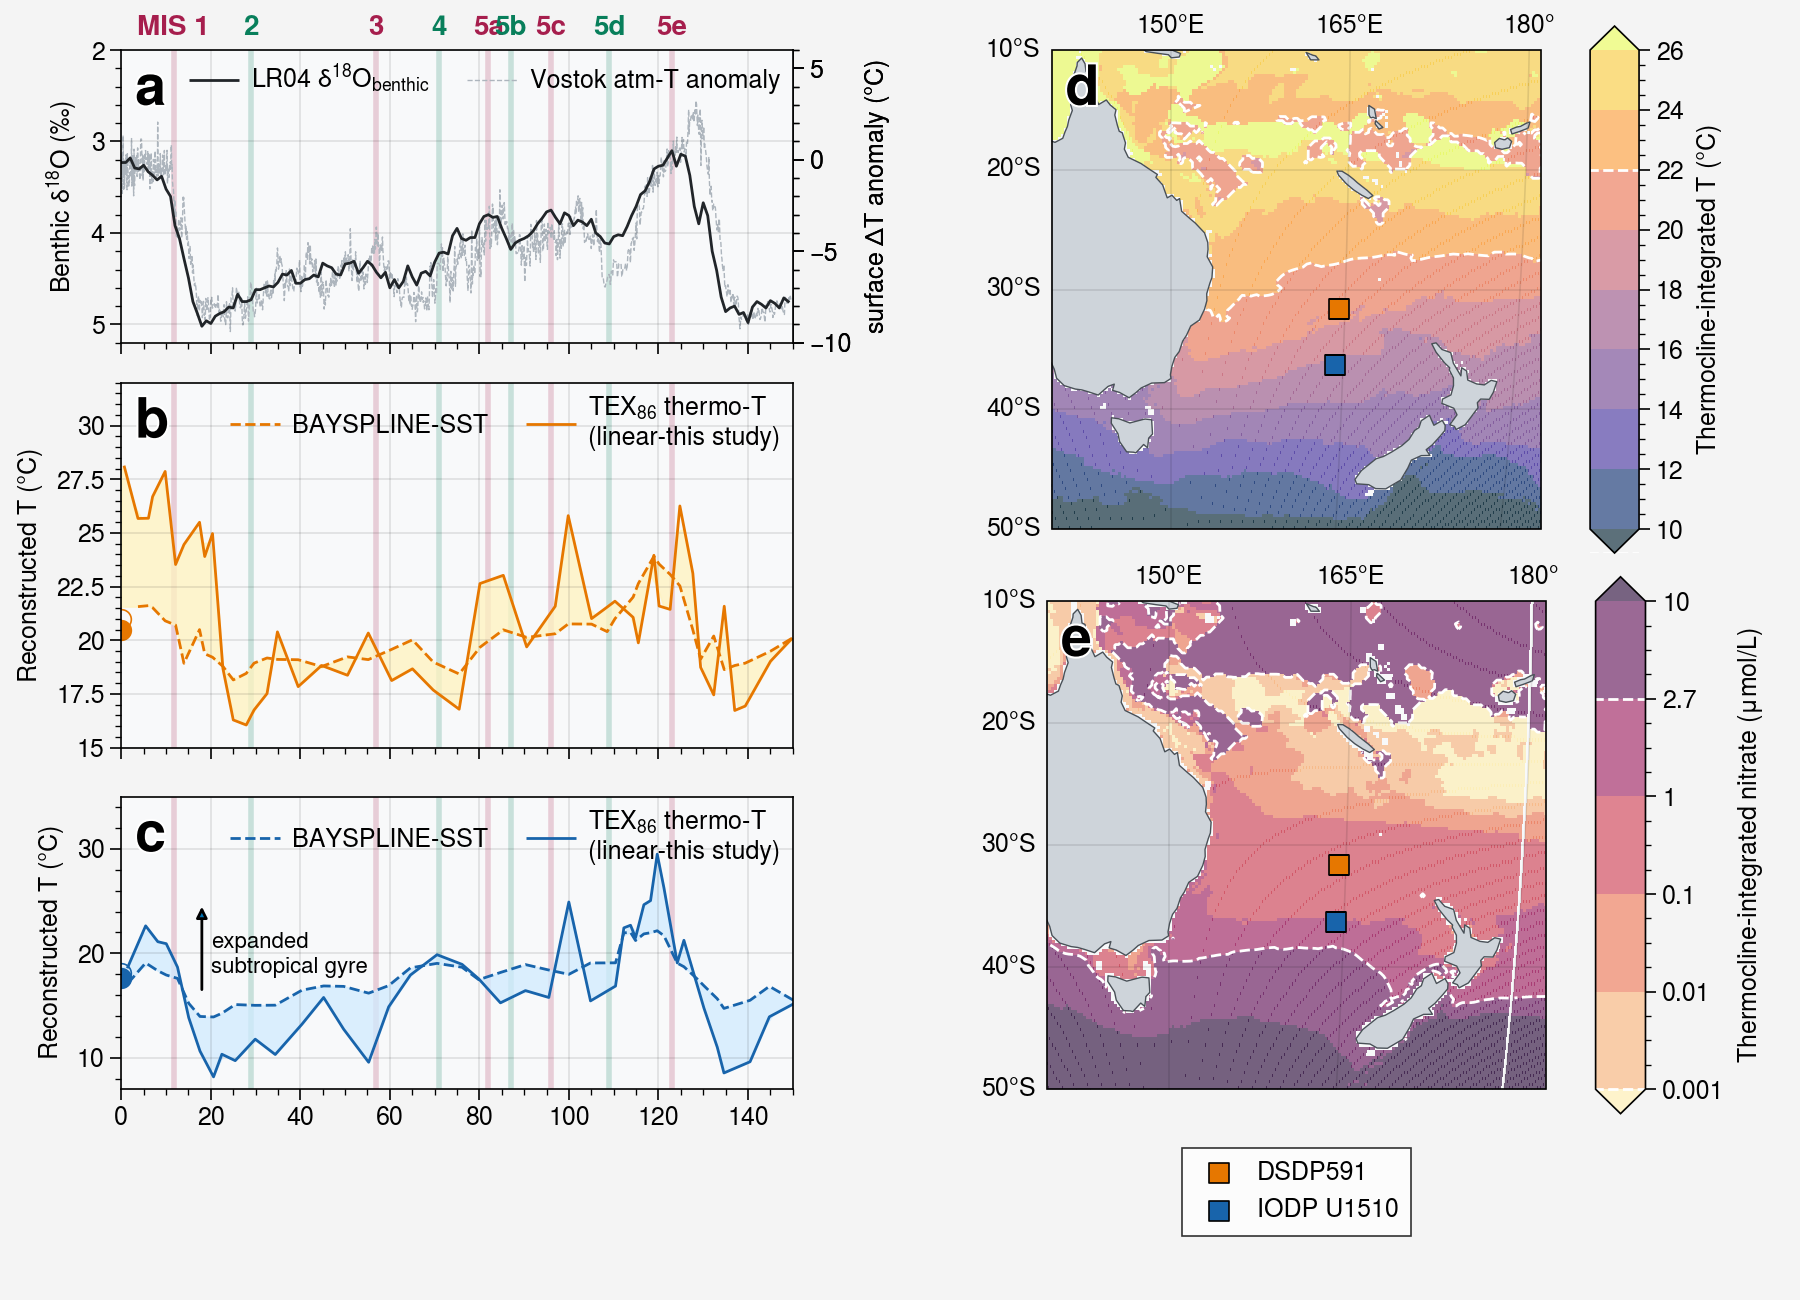

In [41]:
array = [
    [1,1,4,4,4],
    [1,1,4,4,4],
    [2,2,4,4,4],
    [2,2,5,5,5],
    [3,3,5,5,5],
    [3,3,5,5,5],   
]
fig, axs = plot.subplots(
    array,
    figsize=(9,6.5),
    wspace=0,
    sharey=0,
    proj=(None,None,None,'eck3','eck3'),
    proj_kw={'lon_0': 150}
    )
axs.format(facecolor='gray0')
#### plot LR04 benthic d18O
ax = axs[0]

ax2 = ax.twinx()
plot_data = Vostok_deltaTS_df[Vostok_deltaTS_df['Age_kaBP']<150]
plot_x = plot_data['Age_kaBP']
plot_y = plot_data['deltaTS']
ax2.plot(plot_x,plot_y,lw=0.5,c='gray5',ls='--',label='Vostok atm-T anomaly')
ax2.format(
    ylim=(-10,6),
    ylabel='surface $\Delta$T anomaly ($\degree$C)',
)


plot_data = LR04_benthic_df[LR04_benthic_df['Age_kyrBP']<150]
plot_x = plot_data['Age_kyrBP']
plot_y = plot_data['d18O_benthic']
ax.plot(plot_x,plot_y,lw=1,c='gray9',label = 'LR04 $\delta^{18}$O$_{benthic}$')
ax.format(
    ylim=(5.2,2.0),
    ylabel='Benthic $\delta^{18}$O (‰)',
)


h, l = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h+h2,l+l2,loc='ur',ncol=2,frameon=False)
ax.set_zorder(1)
ax2.set_zorder(0)
#### plot uk37-SST and tex86-SST as line plots on the same subplot for comparison 
ax = axs[1]

plot_data = DSDP591_uk37_df.dropna(subset=['SST_bayspline']).sort_values(by='Age_ka').reset_index(drop=True)
plot_x1 = plot_data['Age_ka']
plot_y1 = plot_data['SST_bayspline']
ax.plot(plot_x1,plot_y1,label='BAYSPLINE-SST',c='yellow9',lw=1,ls='--')

plot_data = DSDP591_tex86_df[
    ((DSDP591_tex86_df['BIT']<=0.5)
    &(DSDP591_tex86_df['MI']<=0.5)
    &(DSDP591_tex86_df['%GDGT-0']<=60))].dropna(subset=['sst_new']).sort_values(by='Age_ka').reset_index(drop=True)
plot_x2 = plot_data['Age_ka']
plot_y2 = plot_data['sst_new']
ax.plot(plot_x2,plot_y2,label='TEX$_{86}$ thermo-T\n(linear-this study)',lw=1,c='yellow9')


### shade color between y of two lines ---if tex is higher than uk37, shade red else shade blue
### need to interpolate the two lines to get the y values at the same x

x = np.linspace(0,150,100)
y1 = np.interp(x,plot_x1,plot_y1)
y2 = np.interp(x,plot_x2,plot_y2)
ax.fill_between(x,y1,y2,color='yellow1',alpha=0.75)


h, l = ax.get_legend_handles_labels()
ax.legend(h,l,loc='ur',ncol=2,frameon=False)

ax.format(
    ylim=(15,32),
    ylabel='Reconstructed T ($\degree$C)',
)



#####################################################

ax = axs[2]

plot_data = IODPU1510_uk37_df.dropna(subset=['SST_bayspline']).sort_values(by='Age_ka').reset_index(drop=True)
plot_x1 = plot_data['Age_ka']
plot_y1 = plot_data['SST_bayspline']
ax.plot(plot_x1,plot_y1,label='BAYSPLINE-SST',lw=1,c='blue9',ls='--')

plot_data = IODPU1510_tex86_df[
    ((IODPU1510_tex86_df['BIT']<=0.5)
    &(IODPU1510_tex86_df['MI']<=0.5)
    &(IODPU1510_tex86_df['%GDGT-0']<=60))].dropna(subset=['sst_new']).sort_values(by='Age_ka').reset_index(drop=True)
plot_x2 = plot_data['Age_ka']
plot_y2 = plot_data['sst_new']
ax.plot(plot_x2,plot_y2,label='TEX$_{86}$ thermo-T\n(linear-this study)',lw=1,c='blue9')

### shade pale yellow between y of two lines
### need to interpolate the two lines to get the y values at the same x
x = np.linspace(0,150,100)
y1 = np.interp(x,plot_x1,plot_y1)
y2 = np.interp(x,plot_x2,plot_y2)
ax.fill_between(x,y1,y2,color='blue1',alpha=0.75)

h, l = ax.get_legend_handles_labels()
ax.legend(h,l,loc='ur',ncol=2,frameon=False)


ax.format(
    ylim=(7,35),
    ylabel='Reconstructed T ($\degree$C)',
)

#### add an arrow with annotation showing reduced denitrification during YD and HS1
ax.annotate('',
            xy=(18,16),xytext=(18,25),
            arrowprops=dict(arrowstyle='<|-',lw=1),
            ha='center',va='center',fontsize=8)
ax.text(20,22,'expanded\nsubtropical gyre',
        ha='left',va='top',fontsize=8)
####################################################
ax = axs[3]
ax.format(
    land=True,landcolor='gray4',landzorder=0,
    coast=True,coastcolor='gray7',coastlinewidth=0.5,
    latlim=(-50,-10),lonlim=(-220,-179),
    latlines=10,lonlines=15,
    latlabels='l',lonlabels='t',
)

### plot thermo-T
m=t_sf2tc_da.sel(lat=slice(-60,-10)).plot(ax=ax,
                                        zorder=0,
                                        levels=np.arange(10,27,2),
                                        extend='both',
                                        cmap='thermal',
                                        add_colorbar=False,
                                        alpha=0.65,
                                        rasterized=True)

### add contour line of 25 degC
m2=t_sf2tc_da.sel(lat=slice(-60,-10)).plot.contour(ax=ax,levels=[0,22],
                                                zorder=1,
                                                linewidths=1,
                                                linestyles='dashed',
                                                colors='w',robust=True)

ax.set_title('')

axins1 = inset_axes(
    ax,
    width="10%",
    height="110%",
    loc="center right",
    bbox_to_anchor=(0.2,0,1,1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
axins1.patch.set_alpha(0)
cbar = fig.colorbar(m,
             cax=axins1,
             orientation="vertical",
             label='Thermocline-integrated T ($\degree$C)',
             extend='both'
             )
cbar.add_lines(m2)
cbar.lines[0].set_linestyle('dashed')

####################################################
ax = axs[4]
ax.format(
    land=True,landcolor='gray4',landzorder=0,
    coast=True,coastcolor='gray7',coastlinewidth=0.5,
    latlim=(-50,-10),lonlim=(-220,-179),
    latlines=10,lonlines=15,
    latlabels='l',lonlabels='t',
)


### plot thermocline-integrated nitrate on the map
m=thermocline_nitrate_da.sel(lat=slice(-60,-10)).plot(ax=ax,
                                                    zorder=0,
                                                    levels=[1e-3,1e-2,1e-1,1,lowno3_threshold,10],
                                                    cmap='matter',
                                                    add_colorbar=False,
                                                    alpha=0.65,
                                                    rasterized=True)


### plot contour line for lowno3_threshold μM nitrate
m2=thermocline_nitrate_da.sel(lat=slice(-60,-10)).plot.contour(ax=ax,levels=[0,lowno3_threshold],
                                                zorder=1,
                                                linewidths=1,
                                                linestyles='dashed',
                                                colors='w',robust=True)

ax.set_title('')

axins1 = inset_axes(
    ax,
    width="10%",
    height="110%",
    loc="center right",
    bbox_to_anchor=(0.2,0,1,1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
axins1.patch.set_alpha(0)
cbar = fig.colorbar(m,
             cax=axins1,
             orientation="vertical",
             label='Thermocline-integrated nitrate ($\mu$mol/L)',
             extend='both'
             )
cbar.add_lines(m2)
cbar.lines[0].set_linestyle('dashed')

axins1.yaxis.set_ticklabels(['0.001','0.01','0.1','1',f'{lowno3_threshold}','10'])
### lat/lon for DSDP591 = -31.5843	 164.4487
### lat/lon for IODP U1510 = 36°19.7385′S, 164°33.5220′E, water depth 1238 m

axs[-2:].scatter(164.4487,-31.5843,c='yellow9',
           mec='k',marker='s',s=50,
           label='DSDP591',
           zorder=2)

axs[-2:].scatter(164.33,-36.33,c='blue9',
              mec='k',marker='s',s=50,
              label='IODP U1510',
              zorder=2)

#### plot today's SST from T_da and thermocline-integrated T data
DSDP591_today_sst = T_da.isel(depth=0).sel(lat=-31.5843,lon=164.4487,method='nearest').values
DSDP591_thermoT = t_sf2tc_da.sel(lat=-31.5843,lon=164.4487,method='nearest').values
axs[1].scatter(0,DSDP591_thermoT,c='yellow9',marker='o',s=50)
axs[1].scatter(0,DSDP591_today_sst,mec='yellow9',marker='o',facecolor='none',s=50)

IODPU1510_today_sst = T_da.isel(depth=0).sel(lat=-36.33,lon=164.33,method='nearest').values
IODPU1510_thermoT = t_sf2tc_da.sel(lat=-36.33,lon=164.33,method='nearest').values
axs[2].scatter(0,IODPU1510_thermoT,c='blue9',marker='o',s=50)
axs[2].scatter(0,IODPU1510_today_sst,mec='blue9',marker='o',facecolor='none',s=50)

h, l = ax.get_legend_handles_labels()
ax.legend(h,l,loc='lower center',ncol=1,
          bbox_to_anchor=(0,-0.3,1,1),
          )
axs[:3].format(
    xlim=(0,150),
    xlabel='Age (ka)',
)

axs.format(
    abc=True,abcloc='ul',abcstyle='a',rc_kw={'abc.size':20},
)

### shaded area for Marine Isotope Stages 1 to 6
MIS_ages = [11.7, 29, 57, 71, 82, 87, 96, 109, 123]
MIS_labels = ['MIS 1','2','3','4','5a','5b','5c','5d','5e']
MIS_colors = ['pink9','teal9','pink9','teal9','pink9','teal9','pink9','teal9','pink9']
for ii, age in enumerate(MIS_ages):
    axs[:-2].axvline(age,c=MIS_colors[ii],lw=2,zorder=0,alpha=0.2)
    axs[0].text(age,1.9,MIS_labels[MIS_ages.index(age)],
                c=MIS_colors[ii],
                ha='center',va='bottom',
                fontweight='bold',
                fontsize=10,zorder=0)

fpath = fr'{local_github_path}/figures/'
fname = 'paleo_showcase_SPSTG.pdf'
fig.savefig(os.path.join(fpath,fname),bbox_inches='tight',embed_fonts=True,dpi=1440)

# 4. Supplementary figures

## Fig S1. Ammonia oxidation rate vs nitrate

In [42]:
## Fig. S1: nitrate and ammonium conc. vs ammonia oxidation rate
plot_data_ammOx_nh4 = merged_ammOxR_gridded_ds.where(
    merged_ammOxR_gridded_ds.depth<=thermocline_depth_da)[
        ['ammOxRate_median','NH4_median',
        'ammOxRate_mean','NH4_mean']].to_dataframe().dropna().reset_index()
    
plot_data_ammOx_no3 = merged_ammOxR_gridded_ds.where(
    merged_ammOxR_gridded_ds.depth<=thermocline_depth_da)[[
        'ammOxRate_median','NO3_median',
        'ammOxRate_mean','NO3_mean']].to_dataframe().dropna().reset_index()
plot_data_only_ammOx = merged_ammOxR_gridded_ds.where(merged_ammOxR_gridded_ds.depth<=thermocline_depth_da)[[
    'ammOxRate_median','ammOxRate_mean']].to_dataframe().dropna().reset_index()


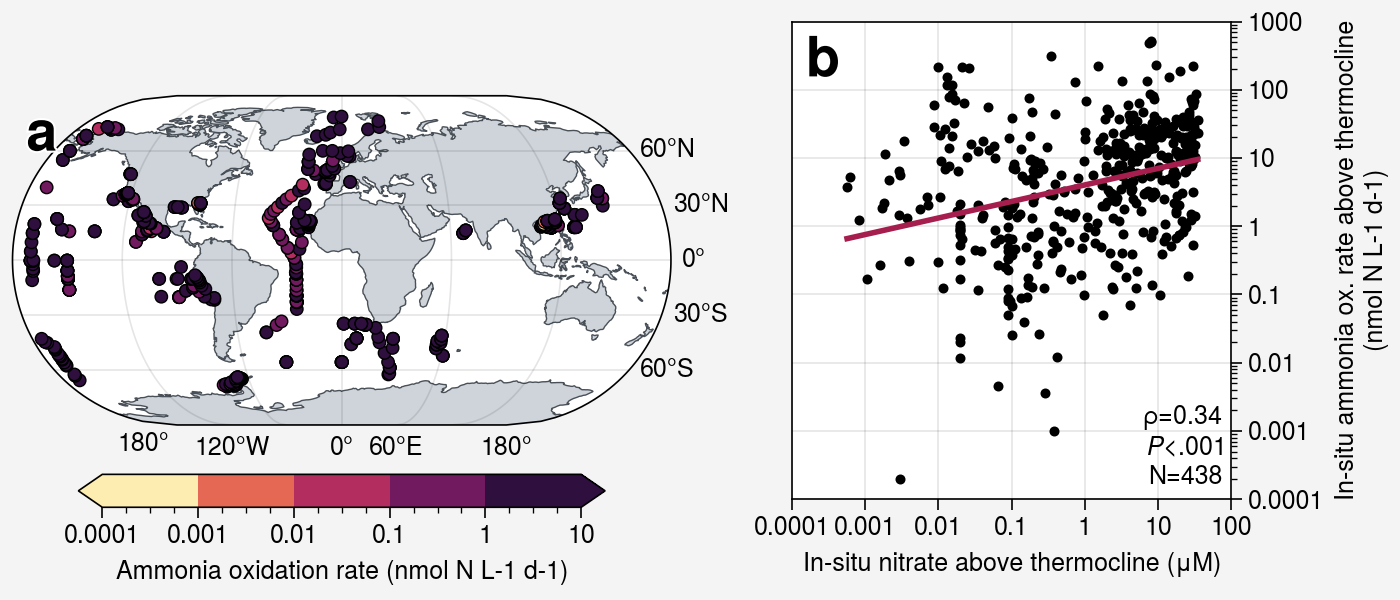

In [43]:
array = [
    [1,2],
]

fig, axs = plot.subplots(array,proj=('eck3',None),
                         wratios=[1.5,1],
                         figsize=(7,3),share=False)

ax = axs[0,0]
ax.format(land=True, landcolor='gray4',landzorder=0,
          coast=True, coastcolor='gray7',coastlinewidth=0.5,coastzorder=1,
          latlabels='r', lonlabels=True)

plot_data = plot_data_only_ammOx
plot_x = plot_data['lon']
plot_y = plot_data['lat']
plot_c = plot_data['ammOxRate_median']
m = ax.scatter(plot_x,plot_y,
              c=plot_c,cmap='matter',
              levels=[1e-4,1e-3,1e-2,1e-1,1e0,1e1],
              robust=True,
              s=20,mec='k',mew=0.5,
              zorder=2)
axins1 = inset_axes(
    ax,
    width="80%",
    height="10%",
    loc="lower center",
    bbox_to_anchor=(0,-0.25,1,1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
axins1.patch.set_alpha(0)
cbar = fig.colorbar(m,
             cax=axins1,
             orientation="horizontal",
             label='Ammonia oxidation rate (nmol N L-1 d-1)',
             extend='both',
             )
axins1.xaxis.set_ticks_position('bottom')
axins1.xaxis.set_label_position('bottom')
axins1.xaxis.set_ticklabels(['0.0001','0.001','0.01','0.1','1','10'])

################################################3
ax = axs[0,1]
plot_data = plot_data_ammOx_no3
plot_x_param = 'NO3_median'
plot_y_param = 'ammOxRate_median'
ax.scatter(plot_data[plot_x_param],plot_data[plot_y_param],m='.',c='k')

### calculate log10 for plot_x and plot_y
plot_data['Log10_'+plot_x_param] = np.log10(plot_data[plot_x_param])
plot_data['Log10_'+plot_y_param] = np.log10(plot_data[plot_y_param])
plot_data[['Log10_'+plot_x_param,'Log10_'+plot_y_param]] = plot_data[['Log10_'+plot_x_param,'Log10_'+plot_y_param]
                                                            ].replace([np.inf,-np.inf],np.nan)
reg_data = plot_data.dropna(subset=['Log10_'+plot_x_param,'Log10_'+plot_y_param]).reset_index(drop=True)
  
### ols fit
ols = LinearRegression()
X = reg_data['Log10_'+plot_x_param].values.reshape(-1,1)
y = reg_data['Log10_'+plot_y_param]
ols.fit(X,y)
slope = ols.coef_[0]
intercept = ols.intercept_
X_pred = np.linspace(X.min(),X.max(),100)
y_pred = ols.predict(X_pred.reshape(-1,1))
ax.plot(10**X_pred,10**y_pred,c='pink9',lw=2,label='Linear fit')
### rho and p-value
rho,pval = scipy.stats.spearmanr(X,y)
pval_label = label_pvalues(pval)
ax.text(0.98,0.02,
        f'$\\rho$={rho:.2f}\n{pval_label}\nN={len(plot_data)}',
        transform=ax.transAxes,
        ha='right',va='bottom')

ax.format(
    ylabel='In-situ ammonia ox. rate above thermocline\n(nmol N L-1 d-1)',
    xlabel='In-situ nitrate above thermocline (μM)',
    xscale='log',
    yscale='log',
    xlim=(1e-4,1e2),
    xticks=[1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2],
    ylim=(1e-4,1e3),
    ytickloc='right'
)


axs.format(
    abc=True,abcloc='ul',abcstyle='a',
    rc_kw={'abc.size':20},
)

fpath = fr'{local_github_path}/figures/'
fname = 'Fig_SI1_gridded_nitrate_with_ammOxR.pdf'
fig.savefig(os.path.join(fpath,fname),dpi=300,bb_inches='tight')

## Fig S2. New core-top measurements

In [44]:
fpath = fr'{local_github_path}/spreadsheets/'
fname = 'ds01_updated_global_coretop_tex.csv'

coretop_raw_df = pd.read_csv(os.path.join(fpath,fname))
coretop_raw_df

,index_column,core_name,core_type,sample_depth_start,sample_depth_end,latitude,longitude,depth,tex86,fGDGT_0,...,fGDGT_2,fGDGT_3,fGDGT_cren,fGDGT_cren_prime,bit,publicationYear,reference_name,remark,reference_link,dataset_DOI
0,JET_RR_00001,GeoB7702-3,GC,5.0000,6.0000,31.6517,34.0733,562.0000,0.6620,NaN,...,NaN,NaN,NaN,NaN,0.2560,2010,Castaneda2010,Data published in Tierney & Tingley (2015),http://dx.doi.org/10.1029/2009PA001740,'https://doi.org/10.25921/wt2r-sc81
1,JET_RR_00002,KNR195-5-5 MC11,MC,6.0000,8.0000,-1.5327,-86.7852,2288.0000,0.6029,0.3306,...,0.0642,0.0049,0.4992,0.0336,0.0268,2025,this study,Reanalysed samples of Chazen2011 by this study,NaN,10.5281/zenodo.14806962
2,JET_RR_00003,KNR195-5-6 MC12,MC,0.0000,1.0000,-3.7105,-81.1153,378.0000,0.5700,NaN,...,NaN,NaN,NaN,NaN,NaN,2011,Chazen2011,Data published in Tierney & Tingley (2015),https://repository.library.brown.edu/studio/it...,'https://doi.org/10.25921/wt2r-sc81
3,JET_RR_00004,KNR195-5-7 MC16,MC,0.0000,1.0000,-3.7502,-81.1358,379.0000,0.5720,NaN,...,NaN,NaN,NaN,NaN,NaN,2011,Chazen2011,Data published in Tierney & Tingley (2015),https://repository.library.brown.edu/studio/it...,'https://doi.org/10.25921/wt2r-sc81
4,JET_RR_00005,KNR195-5-8 MC18,MC,4.0000,6.0000,-3.9690,-81.3100,1024.0000,0.5994,0.2824,...,0.0524,0.0107,0.5608,0.0309,0.0334,2025,this study,Reanalysed samples of Chazen2011 by this study,NaN,10.5281/zenodo.14806962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2099,JET_RR_02100,AMD17_BB2_BC,NaN,NaN,NaN,72.7500,-67.0200,2373.0000,0.3469,0.6800,...,0.0110,0.0020,0.2730,0.0040,NaN,2023,Harning2023,Data from original source,https://doi.org/10.5194/bg-20-229-2023,https://doi.org/10.1594/PANGAEA.956212
2100,JET_RR_02101,AMD17_CASQ1_BC-4,NaN,NaN,NaN,71.4100,-70.8900,702.0000,0.3529,0.6600,...,0.0030,0.0010,0.3180,0.0020,NaN,2023,Harning2023,Data from original source,https://doi.org/10.5194/bg-20-229-2023,https://doi.org/10.1594/PANGAEA.956212
2101,JET_RR_02102,AMD17_176_BC,NaN,NaN,NaN,69.6000,-65.4000,267.0000,0.4000,0.6900,...,0.0030,0.0010,0.2920,0.0020,NaN,2023,Harning2023,Data from original source,https://doi.org/10.5194/bg-20-229-2023,https://doi.org/10.1594/PANGAEA.956212
2102,JET_RR_02103,AMD17_8.1_BC,NaN,NaN,NaN,69.4100,-64.4000,1054.0000,0.3226,0.7100,...,0.0060,0.0010,0.2610,0.0030,NaN,2023,Harning2023,Data from original source,https://doi.org/10.5194/bg-20-229-2023,https://doi.org/10.1594/PANGAEA.956212


This study: 190
TT2015: 865
post TT2015: 1049


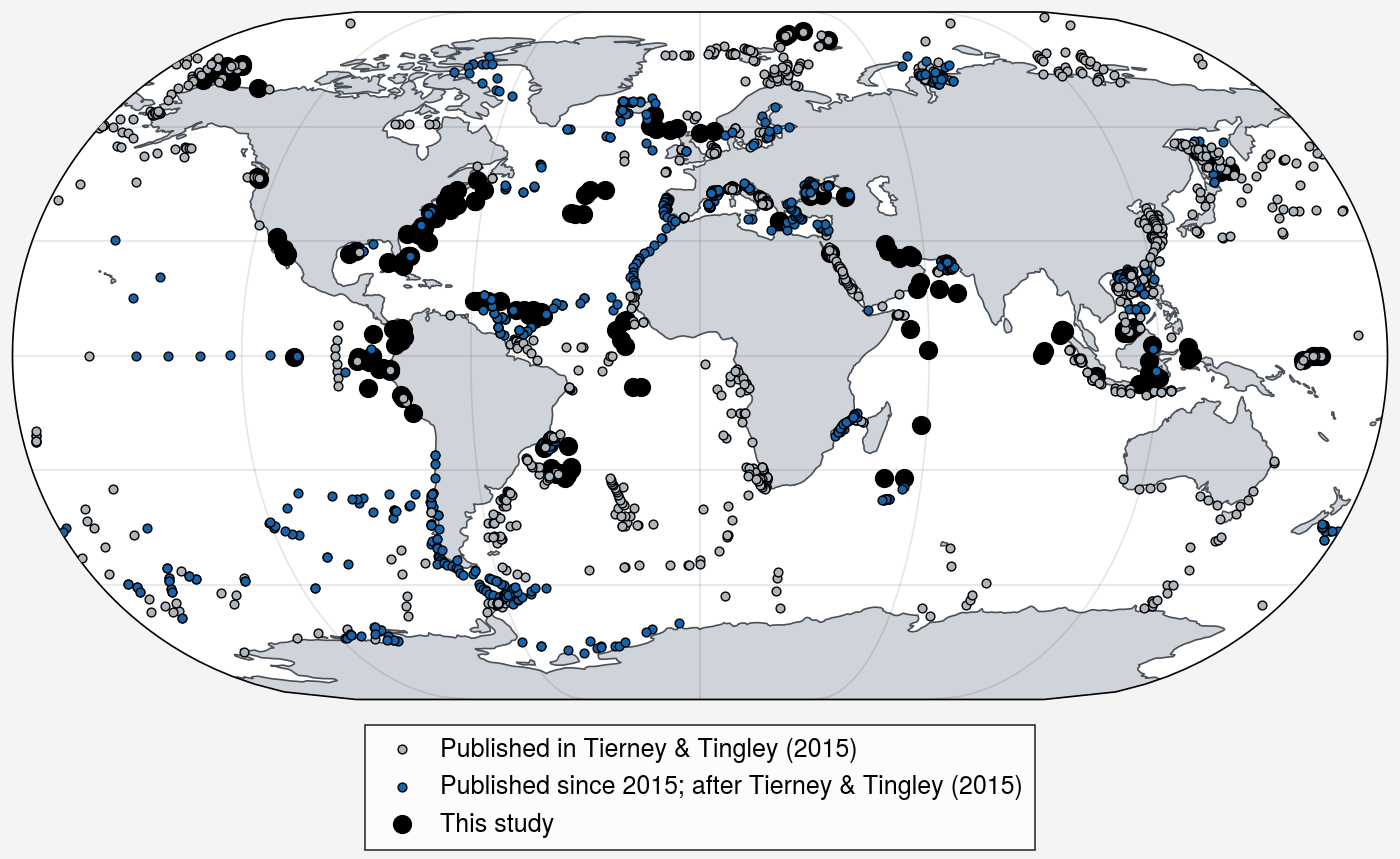

In [58]:
plot.rc.abc = False
fig, axs = plot.subplots(proj=('eck3'),share=0,width=7)

ax = axs[0]
ax.format(
    land=True,landcolor='gray4',landzorder=0,
    coast=True,coastcolor='gray7',coastzorder=1,
)
plot_data = coretop_raw_df
grouped = plot_data.groupby('reference_name')
post_TT2015_data = 0
TT2015_data = 0
thisStudy_data = 0
for name, group in grouped:
    plot_lat = group['latitude']
    plot_lon = group['longitude']
    
    if name == 'this study':
        ax.scatter(plot_lon,plot_lat,
                   c='k',marker='o',s=40,
                   zorder=2,
                   label=name)
        thisStudy_data += len(group)
    elif ((group['publicationYear'].unique()[0] < 2015)
          and name != 'Tierney2015'):
        ax.scatter(plot_lon,plot_lat,
                   c='gray5',marker='o',s=10,
                   mec='k',mew=0.5,
                   zorder=3,
                   label=name)
        post_TT2015_data += len(group)
    else:
        ax.scatter(plot_lon,plot_lat,
                   c='blue9',marker='o',s=10,
                   mec='k',mew=0.5,
                   zorder=3,
                   label=name)
        TT2015_data += len(group)
        
print(f'This study: {thisStudy_data}')
print(f'TT2015: {TT2015_data}')
print(f'post TT2015: {post_TT2015_data}')
h, l = ax.get_legend_handles_labels()
item_idx = [-2,-4,-1]
fig.legend([h[i] for i in item_idx],
           labels=['Published in Tierney & Tingley (2015)',
                   'Published since 2015; after Tierney & Tingley (2015)',
                   'This study'
                   ],
           loc='b',ncol=1,fontsize=10)
        
# fpath = fr'{local_github_path}/figures/'
# fname = 'Fig_SI2_coretop_sites.pdf'
# fig.save(fpath+fname,dpi=330,bbox_inches='tight',embed_fonts=True)


## Fig. S3. d15N vs SST anomalies - Arabian Sea

In [46]:
NIOP905_tex_df.columns

Index(['SampleID', 'SiteName', 'SiteHole', 'MBSF', 'MCD', 'SampleDepth',
       'Formation', 'Country', 'ContinentOcean', 'ModLat', 'ModLon', 'Age',
       'Period', 'Stage', 'StagePosition', 'Biozone', 'AgeFlag', 'ProxyValue',
       'ProxyType', 'ValueType', 'DiagenesisFlag', 'Taxon1', 'Taxon2',
       'Taxon3', 'Environment', 'Ecology', 'AnalyticalTechnique', 'CL', 'Mn',
       'Fe', 'Sr', 'Mg', 'Ca', 'Cawtp', 'MgCa', 'SrCa', 'MnSr', 'NBS120c',
       'Durango', 'MaximumCAI', 'ModWaterDepth', 'CleaningMethod', 'GDGT0',
       'GDGT1', 'GDGT2', 'GDGT3', 'Cren', 'Crenisomer', 'BIT', 'dRI', 'MI',
       'LeadAuthor', 'Year', 'PublicationDOI', 'DataDOI', 'SST'],
      dtype='object')

In [47]:
### create a dataframe that contains uk_sst, tex_sst, and d15N for both sites
age_step = np.arange(0,20.1,0.1)

### get interpolated uk_sst and tex_sst and d15N for 905 to this time step
uk_905 = np.interp(age_step,NIOP905_SST_df['Age_kaBP'],NIOP905_SST_df['uk37'])
uk_sst_905 = np.interp(age_step,NIOP905_SST_df['Age_kaBP'],NIOP905_SST_df['sst'])
tex_905 = np.interp(age_step,NIOP905_tex_df['Age']*1000,NIOP905_tex_df['ProxyValue'])
tex_sst_905 = np.interp(age_step,NIOP905_tex_df['Age']*1000,NIOP905_tex_df['SST'])
d15N_905 = np.interp(age_step,downcore_d15N_df[downcore_d15N_df['core_name']=='NIOP 905']['Age'],downcore_d15N_df[downcore_d15N_df['core_name']=='NIOP 905']['d15N'])
core_name_repeat = ['NIOP 905']*len(age_step)
core_name_repeat = pd.Series(core_name_repeat).astype('category')

### build a df for 905
NIOP905_df = pd.DataFrame({'Age':age_step,
                           'uk':uk_905,
                           'uk_sst':uk_sst_905,
                           'tex':tex_905,
                           'tex_sst':tex_sst_905,
                           'd15N':d15N_905,
                           'core_name':core_name_repeat})
modern_tex = tex_905[:10].mean()
NIOP905_df['tex_residual'] = NIOP905_df['tex'] - modern_tex

### get interpolated uk_sst and tex_sst and d15N for SO42 to this time step
uk_SO42 = np.interp(age_step,SO42_75KL_SST_df['Age_kaBP'],SO42_75KL_SST_df['uk37'])
uk_sst_SO42 = np.interp(age_step,SO42_75KL_SST_df['Age_kaBP'],SO42_75KL_SST_df['sst'])
tex_SO42 = np.interp(age_step,SO42_75KL_tex_df['Age']*1000,SO42_75KL_tex_df['ProxyValue'])
tex_sst_SO42 = np.interp(age_step,SO42_75KL_tex_df['Age']*1000,SO42_75KL_tex_df['SST'])
d15N_SO42 = np.interp(age_step,downcore_d15N_df[downcore_d15N_df['core_name']=='SO42-74KL']['Age'],downcore_d15N_df[downcore_d15N_df['core_name']=='SO42-74KL']['d15N'])
core_name_repeat = ['SO42-74KL']*len(age_step)
core_name_repeat = pd.Series(core_name_repeat).astype('category')

### build a df for SO42
SO42_df = pd.DataFrame({'Age':age_step,
                        'uk':uk_SO42,
                        'uk_sst':uk_sst_SO42,
                        'tex':tex_SO42,
                        'tex_sst':tex_sst_SO42,
                        'd15N':d15N_SO42,
                        'core_name':core_name_repeat})
modern_tex = tex_SO42[:10].mean()
SO42_df['tex_residual'] = SO42_df['tex'] - modern_tex

### join two dataframes
paleo_df = pd.concat([NIOP905_df,SO42_df],ignore_index=True)
paleo_df['core_name'] = paleo_df['core_name'].astype('category')
paleo_df['delta_SST'] = paleo_df['tex_sst'] - paleo_df['uk_sst']
paleo_df

,Age,uk,uk_sst,tex,tex_sst,d15N,core_name,tex_residual,delta_SST
0,0.0000,0.9119,26.6182,0.6660,27.6466,NaN,NIOP 905,-0.0053,1.0284
1,0.1000,0.9123,26.6333,0.6694,27.9290,NaN,NIOP 905,-0.0019,1.2957
2,0.2000,0.9128,26.6520,0.6737,28.2777,NaN,NIOP 905,0.0023,1.6257
3,0.3000,0.9129,26.6593,0.6706,28.0249,NaN,NIOP 905,-0.0007,1.3656
4,0.4000,0.9130,26.6694,0.6671,27.7342,NaN,NIOP 905,-0.0043,1.0648
...,...,...,...,...,...,...,...,...,...
397,19.6000,0.8695,24.6482,0.6470,26.0815,7.7444,SO42-74KL,-0.0365,1.4333
398,19.7000,0.8672,24.5446,0.6474,26.1150,7.6333,SO42-74KL,-0.0361,1.5704
399,19.8000,0.8682,24.5838,0.6492,26.2638,7.5759,SO42-74KL,-0.0343,1.6800
400,19.9000,0.8692,24.6230,0.6510,26.4127,7.5414,SO42-74KL,-0.0325,1.7897


In [55]:


fig, axs = plot.subplots(ncols=2,nrows=2,
                         figsize=(8,8),
                         sharey=0)

grouped = paleo_df.groupby('core_name')
for i, (name, group) in enumerate(grouped):
        ax = axs[0,i]
        ax.format(
                ltitle=name,
                fontsize=10
        )
        group = group.sort_values(by='Age').reset_index(drop=True)
        ### calculate spearman rho and pval between d15N and delta_SST
        reg_data = group[['d15N','delta_SST']].dropna()
        rho, pval = spearmanr(reg_data['d15N'],reg_data['delta_SST'])
        pval_label = label_pvalues(pval)
        ax.text(0.98,0.02,f'Full data\n$\\rho$={rho:.2f}\n{pval_label}\n(n={len(group)})',
                transform=ax.transAxes,
                ha='right',va='bottom')
        
        
        group_YD = group[(group['Age']>=11.7) & (group['Age']<=12.9)]
        ### calculate spearman rho and pval between d15N and delta_SST during YD
        reg_data_YD = group_YD[['d15N','delta_SST']].dropna()
        rho_YD, pval_YD = spearmanr(reg_data_YD['d15N'],reg_data_YD['delta_SST'])
        pval_label_YD = label_pvalues(pval_YD)
        ax.text(0.75,0.02,f'Younger Dryas\n$\\rho$={rho_YD:.2f}\n{pval_label_YD}\n(n={len(group_YD)})',
                transform=ax.transAxes,
                ha='right',va='bottom')
        
        group_HS1 = group[(group['Age']>=14.7) & (group['Age']<=17.5)]
        ### calculate spearman rho and pval between d15N and delta_SST during HS1
        reg_data_HS1 = group_HS1[['d15N','delta_SST']].dropna()
        rho_HS1, pval_HS1 = spearmanr(reg_data_HS1['d15N'],reg_data_HS1['delta_SST'])
        pval_label_HS1 = label_pvalues(pval_HS1)
        ax.text(0.02,0.02,f'Heinrich Stadial 1\n$\\rho$={rho_HS1:.2f}\n{pval_label_HS1}\n(n={len(group_HS1)})',
                transform=ax.transAxes,
                ha='left',va='bottom')
        group_nonYDHS1 = group[(group['Age']<11.7) | (group['Age']>12.9) & ((group['Age']<14.7) | (group['Age']>17.5))]
        
        ### plot non-events data
        plot_x = group_nonYDHS1['d15N']
        plot_y = group_nonYDHS1['delta_SST']
        plot_c = group_nonYDHS1['Age']
        m = ax.scatter(plot_x,plot_y,
                        c=plot_c,levels=np.arange(0,20.1,2),
                        mec='k',lw=1,label='Non-events',
                        alpha=0.5)
        
        ### plot YD and HS1 data
        plot_x = group_YD['d15N']
        plot_y = group_YD['delta_SST']
        plot_c = group_YD['Age']
        ax.scatter(plot_x,plot_y,m='s',
                c=plot_c,levels=np.arange(0,20.1,2),
                mec='k',lw=1,label='Younger Dryas (12.9-11.7 ka)',)
        
        plot_x = group_HS1['d15N']
        plot_y = group_HS1['delta_SST']
        plot_c = group_HS1['Age']
        ax.scatter(plot_x,plot_y,m='^',
                c=plot_c,levels=np.arange(0,20.1,2),
                mec='k',lw=1,label='Heinrich Stadial 1 (17.5-14.7 ka)',)
        
        ### plot d15N vs tex_residuals
        ax = axs[1,i]
        ax.format(
                ltitle=name,
                fontsize=12
        )
        
        group = group.sort_values(by='Age').reset_index(drop=True)
        ### calculate spearman rho and pval between d15N and delta_SST
        reg_data = group[['d15N','tex_residual']].dropna()
        rho, pval = spearmanr(reg_data['d15N'],reg_data['tex_residual'])
        pval_label = label_pvalues(pval)
        ax.text(0.98,0.02,f'Full data\n$\\rho$={rho:.2f}\n{pval_label}\n(n={len(group)})',
                transform=ax.transAxes,
                ha='right',va='bottom')
        group_YD = group[(group['Age']>=11.7) & (group['Age']<=12.9)]
        ### calculate spearman rho and pval between d15N and delta_SST during YD
        reg_data_YD = group_YD[['d15N','tex_residual']].dropna()
        rho_YD, pval_YD = spearmanr(reg_data_YD['d15N'],reg_data_YD['tex_residual'])
        pval_label_YD = label_pvalues(pval_YD)
        ax.text(0.75,0.02,f'Younger Dryas\n$\\rho$={rho_YD:.2f}\n{pval_label_YD}\n(n={len(group_YD)})',
                transform=ax.transAxes,
                ha='right',va='bottom')
        group_HS1 = group[(group['Age']>=14.7) & (group['Age']<=17.5)]
        ### calculate spearman rho and pval between d15N and delta_SST during YD
        reg_data_HS1 = group_HS1[['d15N','tex_residual']].dropna()
        rho_HS1, pval_HS1 = spearmanr(reg_data_HS1['d15N'],reg_data_HS1['tex_residual'])
        pval_label_HS1 = label_pvalues(pval_HS1)
        ax.text(0.02,0.02,f'Heinrich Stadial 1\n$\\rho$={rho_HS1:.2f}\n{pval_label_HS1}\n(n={len(group_HS1)})',
                transform=ax.transAxes,
                ha='left',va='bottom')
        group_nonYDHS1 = group[(group['Age']<11.7) | (group['Age']>12.9) & ((group['Age']<14.7) | (group['Age']>17.5))]
        ### plot non-events data
        plot_x = group_nonYDHS1['d15N']
        plot_y = group_nonYDHS1['tex_residual']
        plot_c = group_nonYDHS1['Age']
        m = ax.scatter(plot_x,plot_y,
                        c=plot_c,levels=np.arange(0,20.1,2),
                        mec='k',lw=1,label='Non-events',
                        alpha=0.5)
        
        ### plot YD and HS1 data
        plot_x = group_YD['d15N']
        plot_y = group_YD['tex_residual']
        plot_c = group_YD['Age']
        ax.scatter(plot_x,plot_y,m='s',
                c=plot_c,levels=np.arange(0,20.1,2),
                mec='k',lw=1,label='Younger Dryas (12.9-11.7 ka)',)
        
        plot_x = group_HS1['d15N']
        plot_y = group_HS1['tex_residual']
        plot_c = group_HS1['Age']
        ax.scatter(plot_x,plot_y,m='^',
                c=plot_c,levels=np.arange(0,20.1,2),
                mec='k',lw=1,label='Heinrich Stadial 1 (17.5-14.7 ka)',)
        
        
        

    
h, l = axs[0].get_legend_handles_labels()
fig.legend(h,l,loc='bottom',c='k')

axs[0,:].format(
        xlabel='$\delta^{15}$N (‰ vs. air)',
        ylabel=r"Thermo-T$_{TEX86}$ - SST$_{U^{K'}_{37}}$ ($\degree$C)",
        ylim=(-5.5,10)
)

axs[1,:].format(
        xlabel='$\delta^{15}$N (‰ vs. air)',
        ylabel=r"TEX$_{86}$ residuals",
        ylim=(-0.125,0.1)
        )

# axs[2,:].format(
#         xlabel=r"Thermo-T$_{TEX86}$ - SST$_{U^{K'}_{37}}$ ($\degree$C)",
#         ylabel=r"TEX$_{86}$ residuals",
#         ylim=(-0.125,0.1)
#         )

axs.format(abc=True,abcstyle='a',abcloc='l',
           rc_kw={'abc.size':15})
    
### add colorbar
fig.colorbar(m,loc='r',label='Age (thousand years ago; ka)',shrink=0.5)

# fpath = fr'{local_github_path}/figures/'
# fname = 'Fig_SI3_paleo_showcase_d15N_deltaSST_ArabianSea.pdf'
# fig.savefig(os.path.join(fpath,fname),dpi=300,bbox_inches='tight',embed_fonts=True)

In [49]:
%whos

Variable                         Type                       Data/Info
---------------------------------------------------------------------
Corg                             float                      nan
Corg_len                         int                        0
DSDP591_tex86_df                 DataFrame                                           <...>n\n[48 rows x 56 columns]
DSDP591_thermoT                  ndarray                    : 1 elems, type `float32`, 4 bytes
DSDP591_today_sst                ndarray                    : 1 elems, type `float32`, 4 bytes
DSDP591_uk37_df                  DataFrame                      Depth_mbsf   Age_ka  <...>  20.0791        895.7534
Distance                         type                       <class 'geopy.distance.Distance'>
HuberRegressor                   ABCMeta                    <class 'sklearn.linear_mo<...>l._huber.HuberRegressor'>
IODPU1510_tex86_df               DataFrame                                           <...>n\n[45 rows 